* Please do not remove this note and add notes below for any comments for this codes

* #### Created by 경제모형실 서범석 at 2023.8월
PRISM-now computes the central ensemble forecast using dynamic quantile selection and estimate ensemble distribution by approximating the base model distribution to a parametric skewed t-distribution.

* #### Modified by 경제모형실 서범석 at 2023.12월
상명대 이동진 교수님의 조언에 따라 아웃라이어를 제거하던 과정을 배제하였음

* #### Distibuted to 경제모형실 조형배 at 2024.6월
경제모형실 조형배 조사역에게 공유

* #### Modified by 커뮤니케이션국 조형배 at 2025.12월
논문 Revision 위한 24Q1 boxplots 추가

## 0. <font color=blue> Import APIs

In [1]:
# import enlighten

In [2]:
import os, copy
from os import walk
from os import path
from pathlib import Path
import pickle
import pandas as pd
import numpy as np
import datetime as dt
from dateutil.relativedelta import relativedelta
from tqdm.notebook import tqdm

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import matplotlib.cbook as cbook

In [5]:
import statsmodels.api as sm
import statsmodels as sm_

In [6]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
from itertools import product
import warnings

In [7]:
from pathlib import Path

In [8]:
from scipy import optimize
from scipy.optimize import minimize

### 0-1.Set environment

In [9]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


In [10]:
def rmse(y_pred,y_true):
    return np.sqrt(np.mean((y_pred-y_true)**2))
def mae(y_pred,y_true):
    return np.mean(np.abs(y_pred-y_true))

In [11]:
# from matplotlib import font_manager as fm
# font_dirs = ['D:/8.work/font/']
# font_files = fm.findSystemFonts(fontpaths=font_dirs)

# for font_file in font_files:
#     fm.fontManager.addfont(font_file)

# # set font
# plt.rcParams['font.family'] = 'Malgun Gothic'
# plt.rcParams['axes.unicode_minus'] = False

## 1. <font color=blue> Analysis

#### <font color=red> Today | Today | Today | Today | Today | Today | Today | Today | Today | Today | Today | Today | </font>

In [12]:
TODAY = '240610'

#### <font color=red> Today | Today | Today | Today | Today | Today | Today | Today | Today | Today | Today | Today | </font>

In [13]:
os.getcwd()

'/content'

### 1-0. Base model predicted values

In [14]:
# Old results
SAM = {'2.1': [-0.41,-0.07,0.24],
       '2.8': [0.20,0.31,0.45],
       '3.3': [0.79,0.64,0.77,0.71,0.12],
       '3.13':[0.39,0.25,0.48,0.51,0.27],
       '3.30':[0.51,0.36,0.57,0.84,0.79,0.03],
       '4.11':[0.49,0.36,0.55,0.90,0.79,0.04],
       '4.28':[0.96,0.98,0.91,0.44,0.67],
       '5.8': [0.84,0.87,0.79,0.83,0.77,0.72],
       '5.11':[0.72,0.74,0.70,0.75,0.77,0.65],
       '5.30':[0.67,0.70,0.62,0.98,1.07,0.81],
       '6.9': [0.73,0.74,0.66,0.99,1.07,0.75],
       '6.12':[0.78,0.79,0.70,0.99,1.07,0.75], # DFM 1.21 (6월 수출 및 5월 모니터링 반영시)
       '6.30':[0.91,0.91,0.75,1.09,0.79],
       '7.7': [0.79,0.79,0.70,1.09,0.79],
       '6.30 (2/4)':[0.91,0.91,0.75,1.70,1.09,0.79,0.88,
              1.02,0.38,0.74,0.59,0.62,1.12],
       '6.30 (3/4)':[0.60,0.57,0.80,0.61,0.66,0.98,0.98,
              0.85,0.56,0.72,0.59,0.80,0.86],
       '7.7 (2/4)':[0.79,0.79,0.70,1.60,1.09,0.79,0.93,
              0.88,0.23,0.70,0.53,0.62,1.12],
       '7.7 (3/4)':[0.49,0.47,0.69,0.24,0.66,0.96,0.86,
              0.80,0.46,0.71,0.65,0.81,0.83],
       '7.27 (2/4)':[0.78,0.78,0.69,1.16,1.40,0.79,0.93,
              0.91,0.35,0.77,0.62,0.51,1.12],
       
       '7.27 (3/4)':[0.26,0.26,0.44,0.24,1.24,0.75,1.02,
              0.81,0.10,0.50,0.45,0.78,0.66],
       '7.27 (4/4)':[0.32,0.26,0.45,0.49,0.24,0.94,0.84,
              0.83,0.36,0.73,0.73,0.67,1.12],
       
       '8.4 (3/4)':[0.36,0.36,0.51,0.37,1.41,0.84,0.75,
              0.74,-0.46,0.25,0.54,0.66,0.61],
       '8.4 (4/4)':[0.33,0.27,0.55,0.33,0.70,1.06,1.22,
              0.79,0.43,0.78,0.78,0.61,1.08],
       
       '8.30 (3/4)':[0.29,0.27,0.39,0.29,1.01,0.62,0.71,
              0.45,-0.66,0.08,0.45,0.63,0.50],
       '8.30 (4/4)':[0.38,0.33,0.41,0.09,0.32,0.66,0.85,
              0.65,0.53,0.85,0.79,0.68,0.92],
       
       '9.15 (3/4)':[0.31,0.29,0.40,0.31,1.10,0.59,0.78,
              0.45,-0.68,0.12,0.36,0.65,0.61],
       '9.15 (4/4)':[0.37,0.32,0.37,0.16,0.78,0.42,0.56,
              0.65,0.55,0.87,0.77,0.73,0.99],
       '10.4 (3/4)':[0.62,0.58,0.61,0.30,1.50,0.63,0.84,
              0.71,-0.21,0.46,0.55,0.65,0.33],
       '10.4 (4/4)':[0.65,0.60,0.69,0.10,-1.80,0.90,0.87,
              0.81,0.73,0.98,0.68,0.76,1.40],
       '10.12 (3/4)':[0.64,0.61,0.62,0.30,1.50,0.61,0.81,
              0.70,-0.19,0.52,0.54,0.65,0.26],
       '10.12 (4/4)':[0.66,0.62,0.71,0.04,-1.80,0.31,0.73,
              0.80,1.08,1.30,0.82,0.75,1.37]        }       


BM = {'2.1': ['min','avg','max'],
      '2.8': ['min','avg','max'],
      '3.3': ['BEM1','BEM2','Copula','DFM','LBVAR'],
      '3.13':['BEM1','BEM2','Copula','DFM','LBVAR'],
      '3.30':['BEM1','BEM2','Copula','DFM','LBVAR','TFM'],
      '4.11':['BEM1','BEM2','Copula','DFM','LBVAR','TFM'],
      '4.28':['BEM1','BEM2','Copula','DFM','TFM'],
      '5.8':['BEM1','BEM2','Copula','DFM','LBVAR','TFM'],
      '5.11':['BEM1','BEM2','Copula','DFM','LBVAR','TFM'],
      '5.30':['BEM1','BEM2','Copula','DFM','LBVAR','TFM'],
      '6.9':['BEM1','BEM2','Copula','DFM','LBVAR','TFM'],
      '6.12':['BEM1','BEM2','Copula','DFM','LBVAR','TFM'],
      '6.30':['L-DFM1','L-DFM2','Copula','LBVAR','TFM'],      
      '7.7':['L-DFM1','L-DFM2','Copula','LBVAR','TFM'],  
  '6.30 (2/4)':['L-DFM1','L-DFM2','Copula','K-DFM','LBVAR','TFM','T-M',
             'VAR','LQR','OptimARIMA','SVR-KNN','RF-DVS','S-XGB'],
  '6.30 (3/4)':['L-DFM1','L-DFM2','Copula','K-DFM','LBVAR','TFM','T-M',
             'VAR','LQR','OptimARIMA','SVR-KNN','RF-DVS','S-XGB'],   
  '7.7 (2/4)':['L-DFM1','L-DFM2','Copula','K-DFM','LBVAR','TFM','T-M',
             'VAR','LQR','OptimARIMA','SVR-KNN','RF-DVS','S-XGB'],
  '7.7 (3/4)':['L-DFM1','L-DFM2','Copula','K-DFM','LBVAR','TFM','T-M',
             'VAR','LQR','OptimARIMA','SVR-KNN','RF-DVS','S-XGB'],
  '7.27 (2/4)':['BEM1','BEM2','BEM3','DFM','LBVAR','TFM','T-M',
             'VAR','LQR','OptimARIMA','SVR-KNN','RF-DVS','S-XGB'],
  '7.27 (3/4)':['BEM1','BEM2','BEM3','DFM','LBVAR','TFM','T-M',
             'VAR','LQR','OptimARIMA','SVR-KNN','RF-DVS','S-XGB'],
  '7.27 (4/4)':['BEM1','BEM2','BEM3','DFM','LBVAR','TFM','T-M',
             'VAR','LQR','OptimARIMA','SVR-KNN','RF-DVS','S-XGB'],
  '8.4 (3/4)':['BEM1','BEM2','BEM3','DFM','LBVAR','TFM','T-M',
             'VAR','LQR','OptimARIMA','SVR-KNN','RF-DVS','S-XGB'],
  '8.4 (4/4)':['BEM1','BEM2','BEM3','DFM','LBVAR','TFM','T-M',
             'VAR','LQR','OptimARIMA','SVR-KNN','RF-DVS','S-XGB'],
  '8.30 (3/4)':['BEM1','BEM2','BEM3','DFM','LBVAR','TFM','T-M',
             'VAR','LQR','OptimARIMA','SVR-KNN','RF-DVS','S-XGB'],
  '8.30 (4/4)':['BEM1','BEM2','BEM3','DFM','LBVAR','TFM','T-M',
             'VAR','LQR','OptimARIMA','SVR-KNN','RF-DVS','S-XGB'],
  '9.15 (3/4)':['BEM1','BEM2','BEM3','DFM','LBVAR','TFM','T-M',
             'VAR','LQR','OptimARIMA','SVR-KNN','RF-DVS','S-XGB'],
  '9.15 (4/4)':['BEM1','BEM2','BEM3','DFM','LBVAR','TFM','T-M',
             'VAR','LQR','OptimARIMA','SVR-KNN','RF-DVS','S-XGB'],
  '10.4 (3/4)':['BEM1','BEM2','BEM3','DFM','LBVAR','TFM','T-M',
             'VAR','LQR','OptimARIMA','SVR-KNN','RF-DVS','S-XGB'],
  '10.4 (4/4)':['BEM1','BEM2','BEM3','DFM','LBVAR','TFM','T-M',
             'VAR','LQR','OptimARIMA','SVR-KNN','RF-DVS','S-XGB'],
  '10.12 (3/4)':['BEM1','BEM2','BEM3','DFM','LBVAR','TFM','T-M',
             'VAR','LQR','OptimARIMA','SVR-KNN','RF-DVS','S-XGB'],
  '10.12 (4/4)':['BEM1','BEM2','BEM3','DFM','LBVAR','TFM','T-M',
             'VAR','LQR','OptimARIMA','SVR-KNN','RF-DVS','S-XGB']        }       

Target = {'2.1': '2023Q1',
      '2.8': '2023Q1',
      '3.3': '2023Q1',
      '3.13':'2023Q1',
      '3.30':'2023Q1',
      '4.11':'2023Q1',
      '4.28':'2023Q2',
      '5.8': '2023Q2',
      '5.11':'2023Q2',
      '5.30':'2023Q2',
      '6.9': '2023Q2',
      '6.12':'2023Q2',
      '6.30':'2023Q2',
    '6.30 (2/4)':'2023Q2',
    '6.30 (3/4)':'2023Q3',
    '7.7 (2/4)':'2023Q2',
    '7.7 (3/4)':'2023Q3',
    '7.27 (2/4)':'2023Q2',
    '7.27 (3/4)':'2023Q3',
    '7.27 (4/4)':'2023Q4',
    '8.4 (3/4)':'2023Q3',
    '8.4 (4/4)':'2023Q4',          
    '8.30 (3/4)':'2023Q3',
    '8.30 (4/4)':'2023Q4',     
    '9.15 (3/4)':'2023Q3',
    '9.15 (4/4)':'2023Q4',      
    '10.4 (3/4)':'2023Q3',
    '10.4 (4/4)':'2023Q4', 
    '10.12 (3/4)':'2023Q3',
    '10.12 (4/4)':'2023Q4',           
         }



In [15]:
model_names0 = ['BEM1', 'BEM2', 'BEM3', 'DFM', 'LBVAR', 'TFM', 'T-M',
                'VAR', 'LQR', 'OptimARIMA', 'SVR-KNN', 'RF-DVS', 'S-XGB']

In [16]:
new_key = '10.31 (4/4)'
SAM[new_key] = [0.74,0.71,0.78,0.27,0.50,0.83,0.70,
               0.95,1.30,1.39,0.69,0.75,1.43]
BM[new_key] = model_names0
Target[new_key] = '2023Q4'

In [17]:
new_key = '10.31 (1/4)'
SAM[new_key] = [0.31,0.26,0.73,0.25,0.40,0.71,0.72,
               0.83,0.32,0.60,0.32,0.67,0.62]
BM[new_key] = model_names0
Target[new_key] = '2024Q1'

In [18]:
new_key = '11.16 (4/4)'
SAM[new_key] = [0.89,0.86,0.82,0.27,0.35,0.75,0.71,
               1.5,0.79,1.42,0.94,0.69,1.43]
BM[new_key] = model_names0
Target[new_key] = '2023Q4'

In [19]:
new_key = '11.16 (1/4)'
SAM[new_key] = [0.35,0.31,0.66,0.28,0.55,0.66,0.58,
               1.15,0.64,0.70,0.09,0.66,0.62]
BM[new_key] = model_names0
Target[new_key] = '2024Q1'

In [20]:
new_key = '11.30 (4/4)'
SAM[new_key] = [0.77,0.73,0.74,0.25,-0.1,0.65,0.77,
                1.13,0.71,1.00,0.92,0.71,1.44]
BM[new_key] = model_names0
Target[new_key] = '2023Q4'

In [21]:
new_key = '11.30 (1/4)'
SAM[new_key] = [0.39,0.35,0.67,0.24,0.80,0.81,0.52,
                0.95,0.40,0.65,0.21,0.64,0.63]
BM[new_key] = model_names0
Target[new_key] = '2024Q1'

In [22]:
model_names = ['BEM1', 'BEM2', 'BEM3', 'DFM', 'LBVAR', 'TFM', 'T-M',
               'VAR', 'LQR', 'ARIMA', 'SVR-KNN', 'RF-DVS', 'S-XGB']

In [23]:
new_key = '12.19 (4/4)'
SAM[new_key] = [0.81,0.77,0.73,0.23,np.nan,0.64,0.73,
                0.8,0.37,0.69,0.87,0.67,1.32]
BM[new_key] = model_names
Target[new_key] = '2023Q4'

In [24]:
new_key = '12.19 (1/4)'
SAM[new_key] = [0.50,0.46,0.70,0.21,np.nan,0.76,0.77,
                0.77,0.15,0.45,0.20,0.66,0.95]
BM[new_key] = model_names
Target[new_key] = '2024Q1'

In [25]:
new_key = '12.27 (4/4)'
SAM[new_key] = [0.84,0.80,0.75,0.23,np.nan,0.67,0.69,
                0.80,0.43,0.74,0.97,0.66,1.32]
BM[new_key] = model_names
Target[new_key] = '2023Q4'

In [26]:
new_key = '12.27 (1/4)'
SAM[new_key] = [0.55,0.51,0.70,0.22,np.nan,0.80,0.79,
                0.76,0.24,0.52,0.12,0.65,0.97]
BM[new_key] = model_names
Target[new_key] = '2024Q1'

In [27]:
model_names = ['BEM1', 'BEM2', 'BEM3', 'DFM', 'LBVAR', 'TFM', 'T-M',
               'VAR', 'LQR', 'ARIMA', 'SVR-KNN', 'RF-DVS', 'S-XGB']

In [28]:
new_key = '1.4 (4/4)'
SAM[new_key] = [0.82,0.78,0.74,0.22,np.nan,0.67,0.68,
                0.65,0.80,0.94,0.99,0.65,1.32]
BM[new_key] = model_names
Target[new_key] = '2023Q4'

In [29]:
new_key = '1.4 (1/4)'
SAM[new_key] = [0.52,0.48,0.71,0.19,np.nan,0.80,0.74,
                0.79,0.90,0.84,0.18,0.64,0.70]
BM[new_key] = model_names
Target[new_key] = '2024Q1'

In [30]:
new_key = '1.9 (4/4)'
SAM[new_key] = [0.81,0.77,0.73,0.22,np.nan,0.69,0.69,
                0.65,0.80,0.94,1.00,0.65,1.32]
BM[new_key] = model_names
Target[new_key] = '2023Q4'

In [31]:
new_key = '1.9 (1/4)'
SAM[new_key] = [0.57,0.54,0.74,0.19,np.nan,0.84,0.48,
                0.79,0.89,0.85,0.22,0.64,0.70]
BM[new_key] = model_names
Target[new_key] = '2024Q1'

In [32]:
model_names = ['BEM1', 'BEM2', 'BEM3', 'DFM', 'LBVAR', 'TFM', 'T-M',
               'VAR', 'LQR', 'ARIMA', 'SVR-KNN', 'RF-DVS', 'S-XGB']

In [33]:
new_key = '1.30 (1/4)'
SAM[new_key] = [0.16,0.13,0.31,0.63,np.nan,0.94,0.66,
                0.67,0.86,0.80,0.26,0.63,1.08]
BM[new_key] = model_names
Target[new_key] = '2024Q1'

In [34]:
new_key = '1.30 (2/4)'
SAM[new_key] = [0.32,0.27,0.36,0.30,np.nan,0.80,0.82,
                0.79,0.39,0.67,0.38,0.65,1.18]
BM[new_key] = model_names
Target[new_key] = '2024Q2'

In [35]:
model_names = ['BEM1', 'BEM2', 'BEM3', 'DFM', 'LBVAR', 'TFM', 'T-M',
               'VAR', 'LQR', 'ARIMA', 'SVR-KNN', 'RF-DVS', 'S-XGB']

In [36]:
new_key = '2.13 (1/4)'
SAM[new_key] = [0.53,0.50,0.57,0.39,np.nan,0.87,0.45,
                0.32,1.16,0.94,0.46,0.59,0.84]
BM[new_key] = model_names
Target[new_key] = '2024Q1'

In [37]:
new_key = '2.13 (2/4)'
SAM[new_key] = [0.36,0.31,0.53,-0.23,np.nan,0.67,0.57,
                0.48,0.32,0.62,0.30,0.66,0.84]
BM[new_key] = model_names
Target[new_key] = '2024Q2'

In [38]:
model_names = ['BEM1', 'BEM2', 'BEM3', 'DFM', 'LBVAR', 'TFM', 'T-M',
               'VAR', 'LQR', 'ARIMA', 'SVR-KNN', 'RF-DVS', 'S-XGB']

In [39]:
new_key = '3.4 (1/4)'
SAM[new_key] = [0.69,0.69,0.68,0.42,np.nan,0.91,0.31,
                0.41,0.62,0.74,0.46,0.59,0.85]
BM[new_key] = model_names
Target[new_key] = '2024Q1'

In [40]:
new_key = '3.4 (2/4)'
SAM[new_key] = [0.44,0.39,0.65,-0.04,np.nan,0.66,0.49,
                0.48,np.nan,0.61,0.30,0.66,0.70]
BM[new_key] = model_names
Target[new_key] = '2024Q2'

In [41]:
model_names = ['BEM1', 'BEM2', 'BEM3', 'DFM', 'LBVAR', 'TFM', 'T-M',
               'VAR', 'LQR', 'ARIMA', 'SVR-KNN', 'RF-DVS', 'S-XGB']

In [42]:
new_key = '3.15 (1/4)'
SAM[new_key] = [0.59,0.56,0.57,0.67,np.nan,0.98,0.56,
                0.49,0.62,0.82,0.81,0.73,0.88]
BM[new_key] = model_names
Target[new_key] = '2024Q1'

In [43]:
new_key = '3.15 (2/4)'
SAM[new_key] = [0.36,0.31,0.52,1.12,np.nan,0.60,0.52,
                0.50,np.nan,0.35,0.47,0.56,0.88]
BM[new_key] = model_names
Target[new_key] = '2024Q2'

In [44]:
model_names = ['BEM1', 'BEM2', 'BEM3', 'DFM', 'LBVAR', 'TFM', 'T-M',
               'VAR', 'LQR', 'ARIMA', 'SVR-KNN', 'RF-DVS', 'S-XGB']

In [45]:
new_key = '3.28 (1/4)'
SAM[new_key] = [0.70,0.70,0.66,0.69,np.nan,1.02,0.62,
                0.62,np.nan,0.95,0.82,0.71,0.94]
BM[new_key] = model_names
Target[new_key] = '2024Q1'

In [46]:
new_key = '3.28 (2/4)'
SAM[new_key] = [0.29,0.25,0.52,0.92,np.nan,0.51,0.51,
                0.53,np.nan,0.40,0.44,0.46,0.78]
BM[new_key] = model_names
Target[new_key] = '2024Q2'

In [47]:
model_names = ['BEM1', 'BEM2', 'BEM3', 'DFM', 'LBVAR', 'TFM', 'T-M',
               'VAR', 'LQR', 'ARIMA', 'SVR-KNN', 'RF-DVS', 'S-XGB']

In [48]:
new_key = '4.29 (2/4)'
SAM[new_key] = [0.55,0.35,0.72,0.46,np.nan,0.61,0.87,
                0.27,-0.40,0.31,0.95,0.63,0.79]
BM[new_key] = model_names
Target[new_key] = '2024Q2'

In [49]:
new_key = '4.29 (3/4)'
SAM[new_key] = [0.43,0.38,0.71,0.30,np.nan,0.83,0.73,
                0.35,-0.06,0.42,0.82,0.66,0.77]
BM[new_key] = model_names
Target[new_key] = '2024Q3'

In [50]:
model_names = ['BEM1', 'BEM2', 'BEM3', 'DFM', 'LBVAR', 'TFM', 'T-M',
               'VAR', 'LQR', 'ARIMA', 'SVR-KNN', 'RF-DVS', 'S-XGB']

In [51]:
new_key = '5.10 (2/4)'
SAM[new_key] = [0.55,0.35,0.65,0.46,np.nan,0.68,0.85,
                0.40,-0.00,0.48,0.86,0.89,0.79]
BM[new_key] = model_names
Target[new_key] = '2024Q2'

In [52]:
new_key = '5.10 (3/4)'
SAM[new_key] = [0.40,0.35,0.55,0.27,np.nan,0.82,0.86,
                0.31,0.07,0.47,0.75,0.80,0.79]
BM[new_key] = model_names
Target[new_key] = '2024Q3'

In [53]:
model_names = ['BEM1', 'BEM2', 'BEM3', 'DFM', 'LBVAR', 'TFM', 'T-M',
               'VAR', 'LQR', 'ARIMA', 'SVR-KNN', 'RF-DVS', 'S-XGB']

In [54]:
new_key = '5.30 (2/4)'
SAM[new_key] = [0.59,0.40,0.67,0.49,np.nan,0.70,0.92,
                0.55,0.19,0.37,0.69,0.60,0.63]
BM[new_key] = model_names
Target[new_key] = '2024Q2'

In [55]:
new_key = '5.30 (3/4)'
SAM[new_key] = [0.46,0.41,0.61,0.36,np.nan,0.78,0.83,
                0.43,0.08,0.51,0.77,0.71,0.76]
BM[new_key] = model_names
Target[new_key] = '2024Q3'

In [56]:
model_names = ['BEM1', 'BEM2', 'BEM3', 'DFM', 'LBVAR', 'TFM', 'T-M',
               'VAR', 'LQR', 'ARIMA', 'SVR-KNN', 'RF-DVS', 'S-XGB']

In [57]:
new_key = '6.10 (2/4)'
SAM[new_key] = [0.43,0.23,0.58,0.52,np.nan,0.58,np.nan,
                -0.46,-0.47,0.23,0.59,0.67,0.40]
BM[new_key] = model_names
Target[new_key] = '2024Q2'

In [58]:
new_key = '6.10 (3/4)'
SAM[new_key] = [0.43,0.38,0.57,0.45,np.nan,0.70,np.nan,
                0.44,-0.14,0.19,0.54,0.60,1.06]
BM[new_key] = model_names
Target[new_key] = '2024Q3'

In [59]:
bp = np.empty((max([len(SAM[x]) for x in SAM]),len(SAM)))
bp[:] = np.nan

for i,x in enumerate(SAM):
    l = len(SAM[x])
    bp[:l,i] = SAM[x]
    
bp = pd.DataFrame(bp)
bp.columns = SAM.keys()    

#### <font color=red> Today | Today | Today | Today | Today | Today | Today | Today | Today | Today | Today | Today | </font>

In [60]:
TODAY

'240610'

#### <font color=red> Today | Today | Today | Today | Today | Today | Today | Today | Today | Today | Today | Today | </font>

### 1-1. Set modules

In [61]:
"""Main module."""

import numpy as np
from scipy import stats
from scipy.special import beta


class SST:
    # Init Parameters
    def __init__(self, mu, sigma, nu, tau):
        """
        Creates an Instance of the Skewed Student T Distribution.
        In this parameterization the expectation equals mu and standard
        deviation equals sigma.
        :param mu: mu parameter
        :type mu: scalar or array_like
        :param sigma: sigma parameter
        :type sigma: scalar or array_like
        :param nu: nu parameter
        :type nu: scalar or array_like
        :param tau: tau parameter
        :type tau: scalar or array_like
        """
        self.mu = np.asarray(mu).astype(float)
        self.sigma = np.asarray(sigma).astype(float)
        self.nu = np.asarray(nu).astype(float)
        self.tau = np.asarray(tau).astype(float)
        self.c = 2 * self.nu * ((1 + self.nu ** 2) *
                                beta(0.5, self.tau / 2) *
                                self.tau ** 0.5) ** -1
        self.m = ((2 * self.tau ** 0.5) * (self.nu - self.nu ** -1)) / (
                (self.tau - 1) * beta(0.5, 0.5 * self.tau))
        self.s2 = ((self.tau / (self.tau - 2)) * (
                self.nu ** 2 + self.nu ** -2 - 1) - self.m ** 2)
        self.mu_0 = self.mu - (self.sigma * self.m / np.sqrt(self.s2))
        self.sigma_0 = self.sigma / np.sqrt(self.s2)

    # Density Function
    def d(self, y):
        """Density Function
        :param y: distribution values
        :type y: scalar or array_like
        :return: density at the specified y values
        :rtype: array
        """
        mu_0 = self.mu_0
        sigma_0 = self.sigma_0
        c = self.c
        nu = self.nu
        tau = self.tau
        z = (y - mu_0) / sigma_0
        p = np.where(y < mu_0,
                     (c / sigma_0) * (1 + ((nu ** 2) * (z ** 2)) / tau) ** (
                             -(tau + 1) / 2),
                     (c / sigma_0) * (1 + (z ** 2) / ((nu ** 2) * tau)) ** (
                             -(tau + 1) / 2))
        return p

    def q(self, p):
        """Quantile Function / Inverse CDF / Percent Point Function
        :param p: probabilities
        :type p: scalar or array_like
        :return: Quantile values corresponding to the specified probabilities.
        :rtype: array
        """
        p = np.asarray(p).astype(float)
        mu_0 = self.mu_0
        sigma_0 = self.sigma_0
        nu = self.nu
        tau = self.tau
        # Calculate quantile
        quantile = np.where(p <= (1 + nu ** 2) ** -1,
                            mu_0 + (sigma_0 / nu) * stats.t.ppf(
                                (p * (1 + nu ** 2)) * 0.5, tau),
                            mu_0 + sigma_0 * nu * stats.t.ppf(
                                (p * (1 + nu ** 2) - 1 + nu ** 2) / (
                                        2 * nu ** 2), tau)
                            )
        return quantile

    # Cumulative Distribution Function
    def p(self, q):
        """Distribution Function
        :param q: value
        :type q: scalar or array_like
        :return: The probability that the SST distributed variable will take
        a value less than or equal to q.
        :rtype: array
        """
        nu = self.nu
        mu_0 = self.mu_0
        tau = self.tau
        sigma_0 = self.sigma_0
        # Calculate CDF
        prob = np.where(q < mu_0,
                        (2 / (1 + nu ** 2)) * stats.t.cdf(
                            x=(nu * (q - mu_0) / sigma_0), df=tau),
                        (1 / (1 + nu ** 2)) * (
                            1 + 2 * nu ** 2 * (
                                stats.t.cdf(x=(q - mu_0) / (sigma_0 * nu),
                                            df=tau) - 0.5))
                        )
        return prob

    # Draw Random Numbers using Inversion Sampling
    def r(self, n=1):
        """Draws Random Numbers which Follow the SST Distribution
        :param n: sample size
        :type n: int or tuple of return shape, optional
        :return: random sample drawn from the SST distribution
        :rtype: array
        .. note::
           n is ignored if the distribution parameters are provided as
           arrays. In that case, a sample with the shape of the provided arrays
           will be drawn. i.e. n = 1.
        """
        return self.q(p=np.random.random(size=n))

In [62]:
def sstq(params):
    
    nu = params[0]
    tau = params[1]
    
    sstq_ = SST(mu_0, sigma_0, nu, tau)
    
    quantiles = [q10,q25,q75,q90]
    percents = [0.1,0.25,0.75,0.9]
    
    obj = sum([(quantiles[i] - sstq_.q(percents[i]))**2 for i in range(4)])
    
    return obj

In [63]:
len_obs = len(SAM)

In [64]:
MX = pd.DataFrame([[np.nanmean(SAM[list(SAM.keys())[i]]), np.nanstd(SAM[list(SAM.keys())[i]])] for i in range(len_obs)])
MX.columns = ['mean','std']
MX.index = list(SAM.keys())

In [65]:
p_list = [1,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,99]
QX = pd.DataFrame([[np.nanpercentile(SAM[list(SAM.keys())[i]],p) for p in p_list] for i in range(len_obs)])
QX.columns = ['p'+str(p) for p in p_list]
QX.index = list(SAM.keys())

In [66]:
#QX

### 1-2. Outliers <- depricated

In [67]:
XXR = copy.deepcopy(SAM)
for t in SAM.keys():
    q25 = QX.loc[t,'p25']
    q75 = QX.loc[t,'p75']
    IQR = q75 - q25
    
    for i,_ in enumerate(XXR[t]):
        if XXR[t][i] < (q25-1.5*IQR): 
            XXR[t][i] = np.nan
        if XXR[t][i] > (q75+1.5*IQR): 
            XXR[t][i] = np.nan

In [68]:
for i in list(XXR.keys())[37:]:
    XXR[i] = copy.deepcopy(SAM)[i]

In [69]:
for t in list(XXR.keys())[-7:]:
    print(BM[t][4])
    XXR[t][4] = np.nan

LBVAR
LBVAR
LBVAR
LBVAR
LBVAR
LBVAR
LBVAR


In [70]:
XXR_BM = {}
for k in XXR.keys():
    XXR_BM[k] = list(zip(BM[k],XXR[k]))

In [71]:
MXR = pd.DataFrame([[np.nanmean(XXR[list(XXR.keys())[i]]), np.nanstd(XXR[list(XXR.keys())[i]]), np.nanmedian(XXR[list(XXR.keys())[i]])] for i in range(len_obs)])
MXR.columns = ['mean','std','med']
MXR.index = list(XXR.keys())

In [72]:
MXR_ = pd.DataFrame([[np.nanmedian(XXR[list(XXR.keys())[i]]), np.nanstd(XXR[list(XXR.keys())[i]]), np.nanmedian(XXR[list(XXR.keys())[i]])] for i in range(len_obs)])
MXR_.columns = ['median','std', 'med']
MXR_.index = list(XXR.keys())

In [73]:
p_list = [1,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,99]
QXR = pd.DataFrame([[np.percentile(pd.DataFrame(XXR[i]).dropna(),p) for p in p_list] for i in XXR.keys()])
QXR.columns = ['p'+str(p) for p in p_list]
QXR.index = XXR.keys()

In [74]:
# QXR

### 1-3. Estimate skewed t-dist

In [75]:
bounds = [(0.01,10), (2.0,10)] 

In [76]:
params_hat = pd.DataFrame(columns=['nu','tau'])

# DAT = QXR
#=====================
DAT = QXR
#=====================

results = dict()
for t in tqdm(DAT.index):

    mu_0 = MXR.loc[t,'mean']
    sigma_0 = MXR.loc[t,'std']
    q10 = DAT.loc[t,'p10']
    q25 = DAT.loc[t,'p25']
    q75 = DAT.loc[t,'p75']
    q90 = DAT.loc[t,'p90']
    
    res = minimize(sstq, x0=(1,5), bounds=bounds)#, method = 'BFGS')
    results[t] = res
    
    optim = res.x[:2]
    # params_hat = params_hat.append(pd.DataFrame({'nu':optim[0], 'tau':optim[1]},index=[t]))
    params_hat = pd.concat([params_hat, pd.DataFrame({'nu':optim[0], 'tau':optim[1]},index=[t])])


  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipython-input-3962611981.py:33: RuntimeWarning: divide by zero encountered in divide
  self.s2 = ((self.tau / (self.tau - 2)) * (
/tmp/ipython-input-4268209804.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  params_hat = pd.concat([params_hat, pd.DataFrame({'nu':optim[0], 'tau':optim[1]},index=[t])])
/tmp/ipython-input-3962611981.py:33: RuntimeWarning: divide by zero encountered in divide
  self.s2 = ((self.tau / (self.tau - 2)) * (
/tmp/ipython-input-3962611981.py:33: RuntimeWarning: divide by zero encountered in divide
  self.s2 = ((self.tau / (self.tau - 2)) * (
/tmp/ipython-input-3962611981.py:33: RuntimeWarning: divide by zero encountered in divide
  self.s2 = ((self.tau / (self.tau - 2)) * (
/tmp/ipython-input-3962611981.py:

In [77]:
params_hat_prev = params_hat

In [78]:
def xnu(xnu, tau):
    # mu_0=0;
    # sigma_0=10;
    nu=xnu[1] #1.2;
    # tau=2.1;
    # q_0 = 0.5
    tt = SST(mu_0,sigma_0,nu,tau)
    x=xnu[0]
    return tt.d(x)

def xtau(xtau, nu):
    # mu_0=0;
    # sigma_0=10;
    # nu=1.2;
    tau=xtau[1]#2.1;
    # q_0 = 0.5
    tt = SST(mu_0,sigma_0,nu,tau)
    x=xtau[0]
    return tt.d(x)

In [79]:
def plotDat(t, x_list = np.arange(-0.2,1.2,0.01), params_hat=params_hat):
    mu_0 = MXR.loc[t,'mean']
    sigma_0 = MXR.loc[t,'std']
    q10 = QX.loc[t,'p10']
    q25 = QX.loc[t,'p25']
    q75 = QX.loc[t,'p75']
    q90 = QX.loc[t,'p90']
    nu_0 = params_hat.loc[t,'nu']
    tau_0 = params_hat.loc[t,'tau']
    
#     if tau_0==2.0:
#         tau_0 += 0.0000001
    
    return np.array([SST(mu_0,sigma_0,nu_0,tau_0).d(x) for x in x_list])

In [80]:
# x_list = np.arange(0.2,1.4,0.01)
# plt.plot(x_list, plotDat('7.27 (2/4)',x_list))

### 1-4. Dynamic Quantile Selection (DQS) Algorithm

In [81]:
def clamp(n, minn, maxn):
    return max(min(maxn, n), minn)

#### <font color=red> Add current and base quarter index

In [82]:
cp_list = [['7.7 (3/4)','7.7 (2/4)'],
           ['7.27 (3/4)','7.27 (2/4)'],
           ['8.4 (3/4)','7.27 (2/4)'],
           ['8.30 (3/4)','7.27 (2/4)'],
           ['9.15 (3/4)','7.27 (2/4)'],
           ['10.4 (3/4)','7.27 (2/4)'],
           ['10.12 (3/4)','7.27 (2/4)'],
           ['7.27 (4/4)','7.27 (3/4)'], 
           ['8.4 (4/4)','8.4 (3/4)'], 
           ['8.30 (4/4)','8.30 (3/4)'], 
           ['9.15 (4/4)','9.15 (3/4)'], 
           ['10.4 (4/4)','10.4 (3/4)'], 
           ['10.12 (4/4)','10.12 (3/4)'],
           ['10.31 (4/4)','10.12 (3/4)'],
           ['11.16 (4/4)','10.12 (3/4)'],
           ['11.30 (4/4)','10.12 (3/4)'],
           ['12.19 (4/4)','10.12 (3/4)'],
           ['12.27 (4/4)','10.12 (3/4)'],
           ['1.4 (4/4)','10.12 (3/4)'],
           ['1.9 (4/4)','10.12 (3/4)'],
           ['10.31 (1/4)','10.31 (4/4)'],
           ['11.16 (1/4)','11.16 (4/4)'],
           ['11.30 (1/4)','11.30 (4/4)'],
           ['12.19 (1/4)','12.19 (4/4)'],
           ['12.27 (1/4)','12.27 (4/4)'],
           ['1.4 (1/4)','1.4 (4/4)'],
           ['1.9 (1/4)','1.9 (4/4)'],
           ['1.30 (1/4)','1.9 (4/4)'],
           ['2.13 (1/4)','1.9 (4/4)'],
           ['3.4 (1/4)','1.9 (4/4)'],
           ['3.15 (1/4)','1.9 (4/4)'],
           ['3.28 (1/4)','1.9 (4/4)'],
           ['1.30 (2/4)','1.30 (1/4)'],
           ['2.13 (2/4)','2.13 (1/4)'],
           ['3.4 (2/4)','3.4 (1/4)'],
           ['3.15 (2/4)','3.15 (1/4)'],
           ['3.28 (2/4)','3.28 (1/4)'],
           ['4.29 (2/4)','3.28 (1/4)'],
           ['5.10 (2/4)','3.28 (1/4)'],
           ['5.30 (2/4)','3.28 (1/4)'],
           ['6.10 (2/4)','3.28 (1/4)'],
           ['4.29 (3/4)','4.29 (2/4)'],
           ['5.10 (3/4)','5.10 (2/4)'],
           ['5.30 (3/4)','5.30 (2/4)'],
           ['6.10 (3/4)','6.10 (2/4)'],
           ]

In [83]:
# MXR

### 1-5. Compute DQS

In [84]:
qval_ = pd.DataFrame(index = ['7.7 (2/4)', '6.30 (3/4)'])
qval_['q'] = [50,50]
qval_['yhat'] = MXR['mean'][['7.7 (2/4)','6.30 (3/4)']]

qval_['q-'] = [50,50]
qval_['yhat-'] = MXR['mean'][['7.7 (2/4)','6.30 (3/4)']]

for c_,p_ in cp_list:
    MXRdiff = MXR.loc[c_] - MXR.loc[p_]

    std = MXR.loc[c_]['std']
    lev = 200*(std**2)
    disp = MXRdiff['std']
    diff = MXRdiff['mean']

    qval_.loc[c_,'q'] = 50+clamp(np.sign(diff)*max(disp,0)*lev,-50,50)

    qval_.loc[c_,'yhat'] = np.percentile([x for x in XXR[c_] if ~np.isnan(x)],qval_.loc[c_,'q'])
    
    mean = MXR['mean'][c_]
    med = MXR['med'][c_]
    lev = 200

    qval_.loc[c_,'q-'] = 50+clamp(np.sign(diff)*max(disp,0)*(std**2)*np.exp(np.sign(diff)*(mean-med))*lev,-50,50)
    #qval_.loc[t,'q-'] = 50+clamp(np.sign(diff)*max(disp,0)*np.exp(np.sign(diff)*(mean-med)*(std**2))*lev,-50,50)
    qval_.loc[c_,'yhat-'] = np.percentile([x for x in XXR[c_] if ~np.isnan(x)],qval_.loc[c_,'q-'])    
    
    qval_.loc[c_,'mean'] = mean
    qval_.loc[c_,'med'] = med        

In [85]:
qval_

,q,yhat,q-,yhat-,mean,med
7.7 (2/4),50.000000,0.812727,50.000000,0.812727,NaN,NaN
6.30 (3/4),50.000000,0.736923,50.000000,0.736923,NaN,NaN
7.7 (3/4),49.856971,0.689485,49.853181,0.689471,0.663846,0.690
7.27 (3/4),47.911688,0.487470,48.067792,0.488407,0.577692,0.500
8.4 (3/4),50.000000,0.540000,50.000000,0.540000,0.544545,0.540
8.30 (3/4),49.856668,0.450000,49.860090,0.450000,0.474167,0.450
9.15 (3/4),50.000000,0.400000,50.000000,0.400000,0.442727,0.400
10.4 (3/4),50.000000,0.610000,50.000000,0.610000,0.570909,0.610
10.12 (3/4),50.000000,0.620000,50.000000,0.620000,0.633333,0.620
7.27 (4/4),50.000000,0.670000,50.000000,0.670000,0.613846,0.670


## 2.  <font color=blue> Plotting

### 2-1.  Dist plot

#### <font color=red> Change current and base quarter index

In [86]:
c = '6.10 (2/4)'
p = '5.30 (2/4)'

points_cur = pd.Series(XXR[c])
points_cur.name = c
points_pre = pd.Series(XXR[p])
points_pre.name = p

In [87]:
list(enumerate(zip(BM[points_cur.name],SAM[points_cur.name])))

[(0, ('BEM1', 0.43)),
 (1, ('BEM2', 0.23)),
 (2, ('BEM3', 0.58)),
 (3, ('DFM', 0.52)),
 (4, ('LBVAR', nan)),
 (5, ('TFM', 0.58)),
 (6, ('T-M', nan)),
 (7, ('VAR', -0.46)),
 (8, ('LQR', -0.47)),
 (9, ('ARIMA', 0.23)),
 (10, ('SVR-KNN', 0.59)),
 (11, ('RF-DVS', 0.67)),
 (12, ('S-XGB', 0.4))]

In [88]:
# printing x range
x_list = np.arange(-1.0,1.2,0.01)

DQS Prev: 0.5946857389484429  DQS Cur: 0.40468697012082017


/usr/local/lib/python3.12/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 51109 (\N{HANGUL SYLLABLE JANG}) 

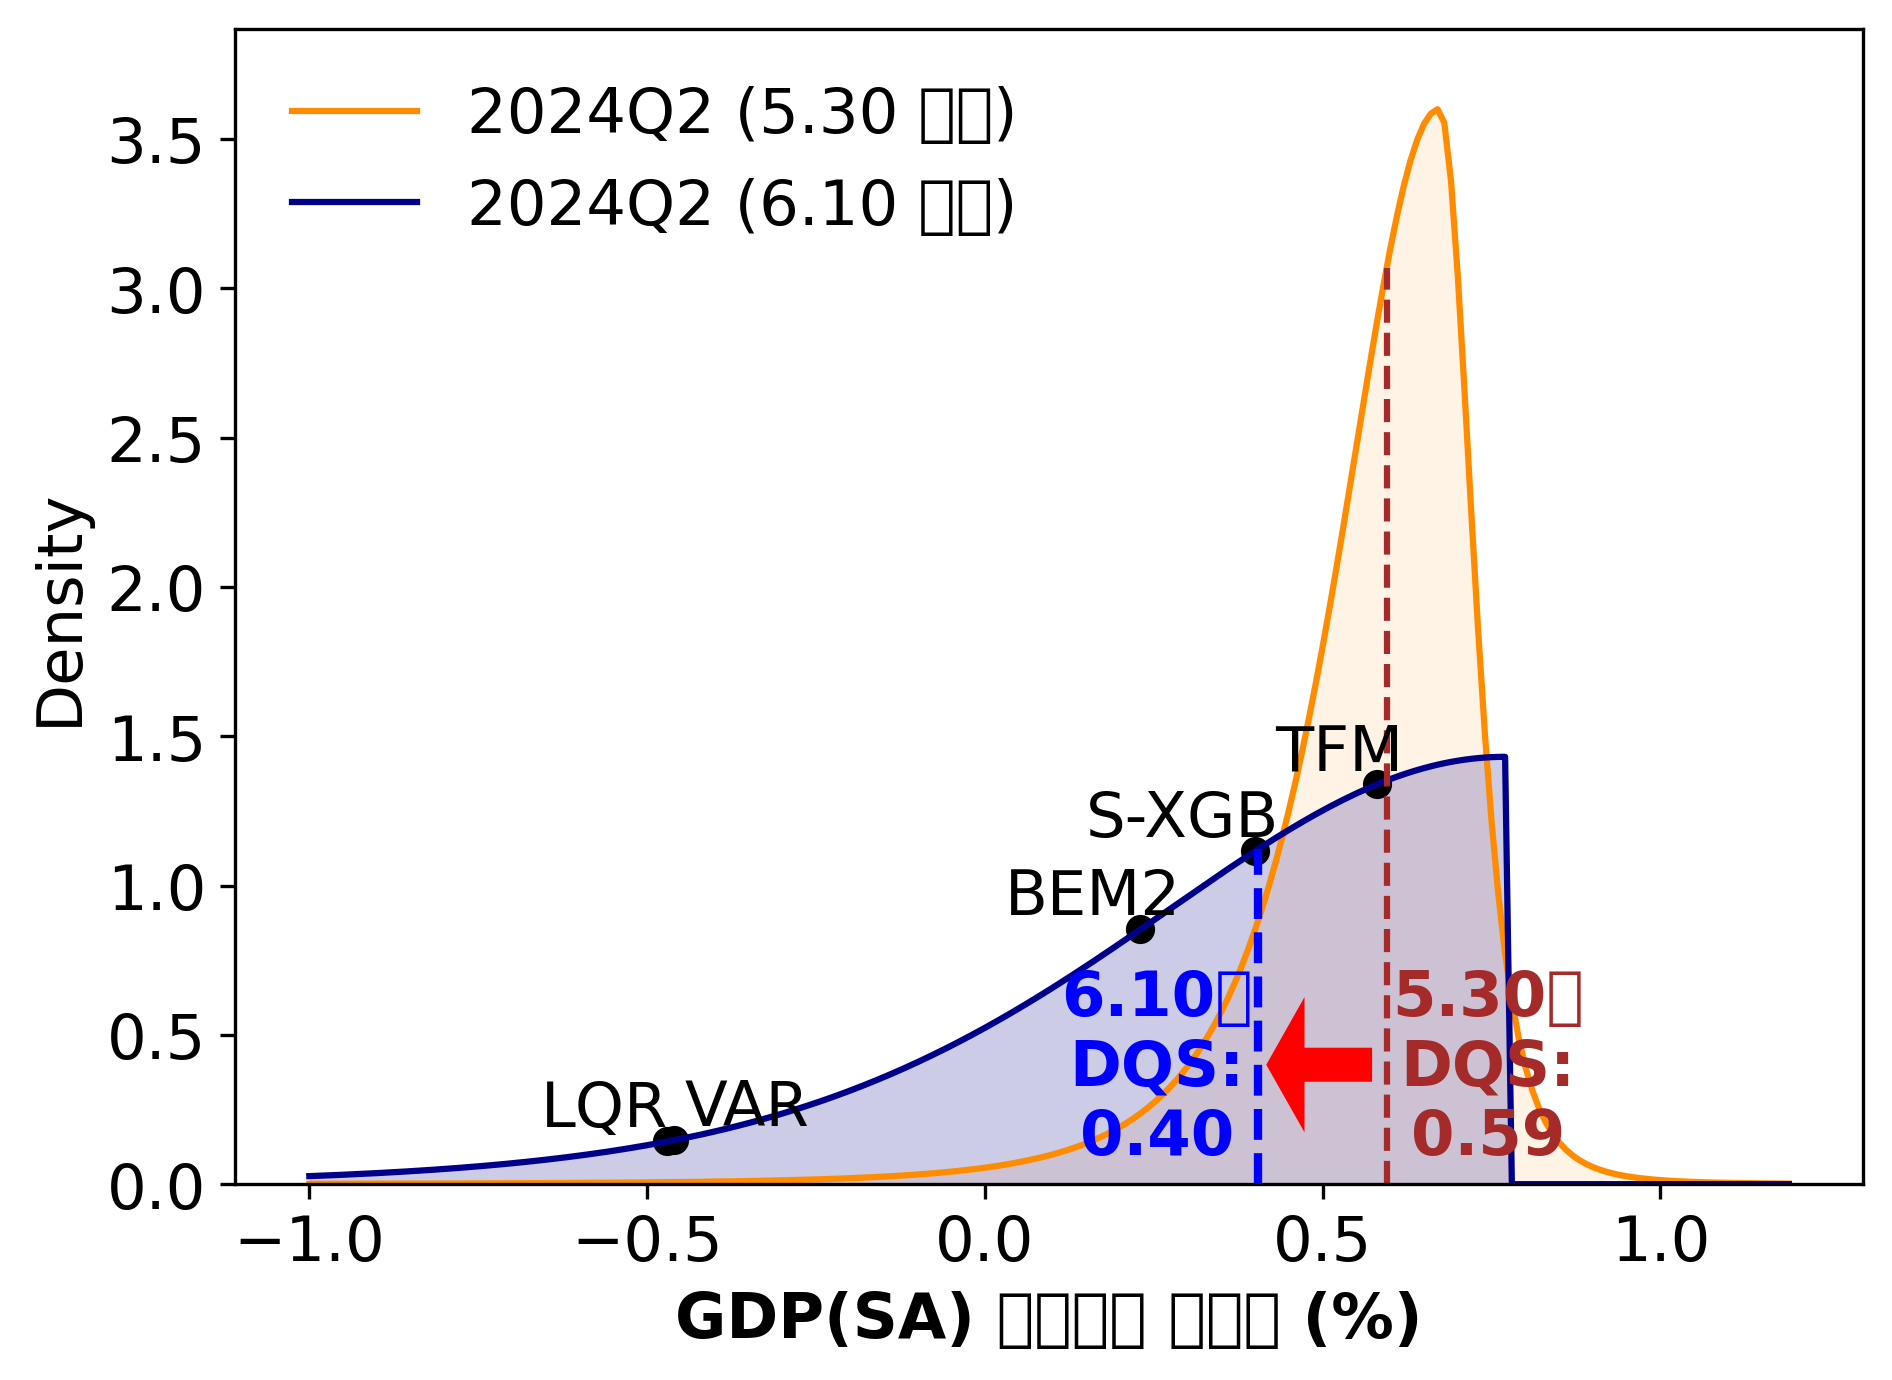

In [89]:
plt.rc('font', size=15)        # 기본 폰트 크기
# plt.rc('axes', labelsize=20)   # x,y축 label 폰트 크기
# plt.rc('xtick', labelsize=50)  # x축 눈금 폰트 크기 
# plt.rc('ytick', labelsize=20)  # y축 눈금 폰트 크기
# plt.rc('legend', fontsize=20)  # 범례 폰트 크기
# plt.rc('figure', titlesize=50) # figure title 폰트 크기

fig, ax = plt.subplots(figsize=(7,5), dpi=300)

ax_p = sns.lineplot(x=x_list, y=plotDat(p,x_list,params_hat_prev), color='darkorange', label='2024Q2 ({} 전망)'.format(points_pre.name.split(' ')[0]))
ax_c = sns.lineplot(x=x_list, y=plotDat(c,x_list), color='darkblue', label='2024Q2 ({} 전망)'.format(points_cur.name.split(' ')[0]))


kdeline_p = ax.lines[0]
kdeline_c = ax.lines[1]

xs_p = kdeline_p.get_xdata()
ys_p = kdeline_p.get_ydata()

xs_c = kdeline_c.get_xdata()
ys_c = kdeline_c.get_ydata()

# mean = np.array(points_cur).mean()

mode_p = qval_['yhat'][points_pre.name]#np.mean(points_pre)#xs_p[np.argmax(ys_p)]
mode_c = qval_['yhat-'][points_cur.name]#np.mean(points_cur)#xs_c[np.argmax(ys_c)]

height_p = np.interp(mode_p, xs_p, ys_p)
height_c = np.interp(mode_c, xs_c, ys_c)

ax_p.fill_between(xs_p, 0, ys_p, facecolor='darkorange', alpha=0.1)
ax_p.vlines(mode_p, 0, height_p, color='brown', ls='--')
ax_c.fill_between(xs_c, 0, ys_c, facecolor='darkblue', alpha=0.2)
ax_c.vlines(mode_c, 0, height_c, color='blue', ls='--', lw=2)

plt.text(mode_c-0.15,0.1,'6.10일\nDQS:\n'+'{:.2f}'.format(np.round(mode_c,2)), color='blue',horizontalalignment='center', weight='bold')
plt.text(mode_p+0.15,0.1,'5.30일\nDQS:\n'+'{:.2f}'.format(np.round(mode_p,2)), color='brown',horizontalalignment='center', weight='bold')
print('DQS Prev:',mode_p,' DQS Cur:', mode_c)

def BM_annotate(i, neg=1):
    h = np.interp(points_cur[i], xs_c, ys_c)
    plt.scatter(points_cur[i],h, color='k')    
    text = BM[c][i]
    if neg>=1:
        plt.text(points_cur[i]+(neg-1)*len(text)/40,h+0.05,text)
    elif neg<1:
        plt.text(points_cur[i]+neg*len(text)/40,h+0.05,text)

# select models you want to print on the dist.
BM_annotate(i = 12, neg=-2)
BM_annotate(i = 1, neg=-2)
# BM_annotate(i = 3, neg=-1)
BM_annotate(i = 5, neg=-2,)
# BM_annotate(i = 6,neg=-1)
BM_annotate(i = 7,neg=+1.2)
BM_annotate(i = 8,neg=-2.5)
# BM_annotate(i = 9, neg=-1)
# BM_annotate(i = 10)
# BM_annotate(i = 11)
# BM_annotate(i = 12)


# plot formatting
plt.legend(prop={'size': 15}, frameon=False, loc=2)
plt.xlabel('GDP(SA) 전기대비 성장률 (%)', weight='bold')
plt.ylabel('Density')#, weight='bold')

plt.ylim((0,max(height_p,height_c)+0.8))
# ylocs, ylabels = plt.yticks()
# plt.yticks([0,1,2,3,4],[0,1,2,3,4])
# plt.ylim((0,2.3))

plt.arrow(0.57, 0.4, -0.1, 0,
          head_width = 0.4,
          head_length = 0.05,
          width = 0.1,
          color ='red')

# plt.savefig('./fig/now_dens_t__{}__.png'.format(TODAY), bbox_inches='tight', dpi=300)

### 2-2.  Box plot trend

In [90]:
bp = np.empty((max([len(XXR[x]) for x in XXR]),len(XXR)))
bp[:] = np.nan

for i,x in enumerate(XXR):
    l = len(XXR[x])
    bp[:l,i] = XXR[x]
    
bp = pd.DataFrame(bp)
bp.columns = XXR.keys()    

In [91]:
bp0 = copy.deepcopy(bp)

In [104]:
tps = [
 '1.30 (1/4)',
 '2.13 (1/4)',
 '3.4 (1/4)',
 '3.15 (1/4)',
 '3.28 (1/4)',
 ]

In [105]:
bp = bp0.loc[:,tps]

In [106]:
min_list = np.min(bp,axis=0)
max_list = np.max(bp,axis=0)
mean_list = qval_['yhat'][tps]

In [107]:
plt.rcParams['text.usetex'] = False

In [108]:
for t in tps:
    max_list[t] = QXR.loc[t,'p95']
    min_list[t] = QXR.loc[t,'p5']
    mean_list[t] = qval_.loc[t,'yhat'] #MXR['mean'][t]

In [109]:
# t = '7.7 (3/4)'
for t in tps:
    for i,x in enumerate(bp[t]):
        if bp[t][i] < min_list[t]:
            bp[t][i] = min_list[t]
        if bp[t][i] > max_list[t]:
            bp[t][i] = max_list[t]

/tmp/ipython-input-2208112794.py:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  bp[t][i] = min_list[t]
/tmp/ipython-input-2208112794.py:7: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values t

In [132]:
temp = list(bp.columns)

In [133]:
temp = [x[:-6] for x in temp]

In [135]:
bp.columns = temp

/tmp/ipython-input-1912688116.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  box_plot = sns.boxplot(
/tmp/ipython-input-1912688116.py:11: UserWarning: The palette list has more values (12) than needed (5), which may not be intended.
  box_plot = sns.boxplot(


(-0.2, 1.6)

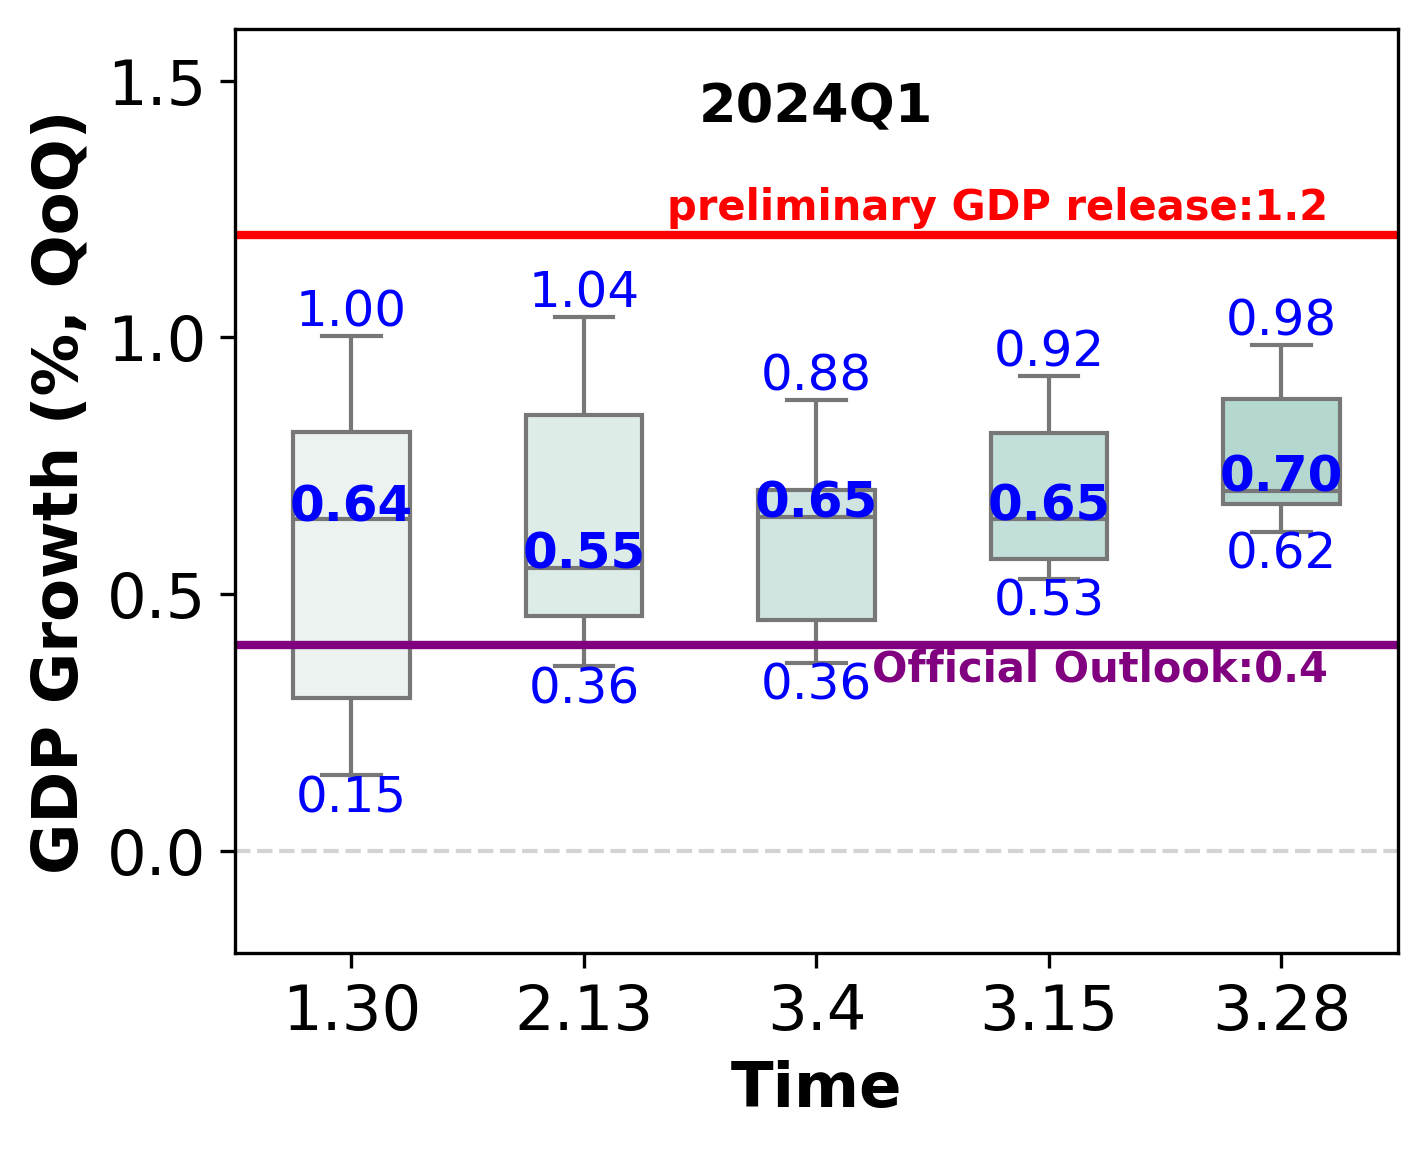

In [151]:
# sns.color_palette()
# sns.set_palette('hls',1)
# sns.reset_orig()
# sns.color_palette(palette=None)
# sns.set(color_codes=True)

fs = 12

plt.rc('font', size=15) 
fig, ax = plt.subplots(figsize=(5,4), dpi=300)
box_plot = sns.boxplot(
    x = [x[1] for x in bp.stack().index],
    y = bp.stack().loc[[x for x in bp.stack().index]],
    ax = ax,
    whis=(0, 100),
    width=0.5, palette=sns.color_palette("light:#5A9",n_colors=12), saturation=1,  linewidth=1)


plt.ylabel('GDP Growth (%, QoQ)', weight='bold')
plt.xlabel('Time', weight='bold')


medians = np.array(mean_list)
for xtick in box_plot.get_xticks():
    t=plt.text(xtick, medians[xtick], "{:.2f}".format(medians[xtick]),
            horizontalalignment='center',size=fs,color='blue', weight='semibold')
#     t.set_bbox(dict(facecolor='w', alpha=0.5, edgecolor='None'))

medians = np.array(min_list)
for xtick in box_plot.get_xticks():
    plt.text(xtick, medians[xtick]-0.07, "{:.2f}".format(medians[xtick]),
            horizontalalignment='center',size=fs,color='blue')#,weight='semibold')
    
medians = np.array(max_list)
for xtick in box_plot.get_xticks():
    plt.text(xtick, medians[xtick]+0.02, "{:.2f}".format(medians[xtick]),
            horizontalalignment='center',size=fs,color='blue')#,weight='semibold')    
    
# adj_hgt = -0.05
# plt.text(-0.4, +0.03+adj_hgt, '- 95% 분위값',
#             horizontalalignment='left',size=fs-2,color='blue')#,weight='semibold')  
# plt.text(1.0, 0.03+adj_hgt, '- 전망치',
#             horizontalalignment='left',size=fs-2,color='blue',weight='semibold')    
# plt.text(+2, 0.03+adj_hgt, '- 5% 분위값',
#             horizontalalignment='left',size=fs-2,color='blue')#,weight='semibold')  


plt.text(2, 1.45, '2024Q1',
            horizontalalignment='center',verticalalignment='center',size=fs+1,color='k',weight='semibold')  

# plt.text(14, 1.45, '2분기',
#             horizontalalignment='center',verticalalignment='center',size=fs+1,color='k',weight='semibold') 
# plt.text(26, 1.35, '22024\n1분기',
#             horizontalalignment='center',verticalalignment='center',size=fs+1,color='k',weight='semibold') 
# plt.text(35, 1.35, '2분기',
#             horizontalalignment='center',verticalalignment='center',size=fs+1,color='k',weight='semibold') 

plt.axhline(y=0,ls='--',lw=1, color='lightgray')


# plt.axvline(x=11.5,ls='--',lw=1, color='black')
# plt.axvline(x=20.5,ls='--',lw=1, color='black')
# plt.axvline(x=32.5,ls='--',lw=1, color='black')

pre_end=0.5
plt.plot([-0.5,4.5],[1.2,1.2],lw=2,color='red')
plt.text(4.2, 1.23, 'preliminary GDP release:1.2',
            horizontalalignment='right',size=10,color='red',weight='semibold')  


plt.plot([-0.5,4.5],[0.4,0.4],lw=2,color='purple')
plt.text(4.2, 0.33, 'Official Outlook:0.4',
            horizontalalignment='right',size=10,color='purple',weight='semibold')  

# plt.plot([7.5,11.5],[0.5,0.5],lw=2,color='purple')
# plt.text(9.5, 0.43, '(4월 점검:0.5)',
#             horizontalalignment='center',size=10,color='purple',weight='semibold')  

# pre_end=0.5
# plt.plot([7.5,20.5],[0.625,0.625],lw=2,color='red')
# plt.text(19.5, 0.53, '(잠정:0.625)',
#             horizontalalignment='center',size=10,color='red',weight='semibold')  

# box_plot = sns.boxplot(
#     x = [x[1] for x in bp1.stack().index],
#     y = bp1.stack().loc[[x for x in bp1.stack().index]],
#     ax = ax,
#     width=0.5, palette=sns.color_palette("Reds"), saturation=1,  linewidth=1)

# x1 = 3.6; x2 = 4.4
# y1 = 0.37; y2 = 1.09
# plt.plot([x1,x2],[y1,y1],lw=2,color='red')
# plt.plot([x1,x1],[y2,y1],lw=2,color='red')
# plt.plot([x2,x2],[y1,y2],lw=2,color='red')
# plt.plot([x2,x1],[y2,y2],lw=2,color='red')

# x1 = 6.6; x2 = 7.4
# y1 = 0.23; y2 = 1.15
# plt.plot([x1,x2],[y1,y1],lw=2,color='red')
# plt.plot([x1,x1],[y2,y1],lw=2,color='red')
# plt.plot([x2,x2],[y1,y2],lw=2,color='red')
# plt.plot([x2,x1],[y2,y2],lw=2,color='red')

plt.xlim((-0.5,4.5))
plt.ylim((-0.2,1.6))


# plt.savefig('./fig/now_ts_t_{}_longterm_.png'.format(TODAY), bbox_inches='tight', dpi=300)

In [214]:
tps = [
#"7.7 (3/4)",
"7.27 (3/4)",
"8.4 (3/4)",
"8.30 (3/4)",
"9.15 (3/4)",
"10.4 (3/4)",
"10.12 (3/4)",
# "9.15 (4/4)",
# "10.4 (4/4)",
# "10.12 (4/4)",
# "10.31 (4/4)",
# "11.16 (4/4)",
#"11.30 (4/4)",
#"12.19 (4/4)",
#"12.27 (4/4)",
#"1.4 (4/4)",
#"1.9 (4/4)"
 ]

In [215]:
bp = bp0.loc[:,tps]

In [216]:
min_list = np.min(bp,axis=0)
max_list = np.max(bp,axis=0)
mean_list = qval_['yhat'][tps]

In [217]:
plt.rcParams['text.usetex'] = False

In [218]:
for t in tps:
    max_list[t] = QXR.loc[t,'p95']
    min_list[t] = QXR.loc[t,'p5']
    mean_list[t] = qval_.loc[t,'yhat'] #MXR['mean'][t]

In [219]:
# t = '7.7 (3/4)'
for t in tps:
    for i,x in enumerate(bp[t]):
        if bp[t][i] < min_list[t]:
            bp[t][i] = min_list[t]
        if bp[t][i] > max_list[t]:
            bp[t][i] = max_list[t]

/tmp/ipython-input-2208112794.py:7: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  bp[t][i] = max_list[t]
/tmp/ipython-input-2208112794.py:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values t

In [220]:
temp = list(bp.columns)

In [221]:
temp = [x[:-6] for x in temp]

In [222]:
bp.columns = temp

/tmp/ipython-input-3737998853.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  box_plot = sns.boxplot(
/tmp/ipython-input-3737998853.py:11: UserWarning: The palette list has more values (12) than needed (6), which may not be intended.
  box_plot = sns.boxplot(


(-0.2, 1.6)

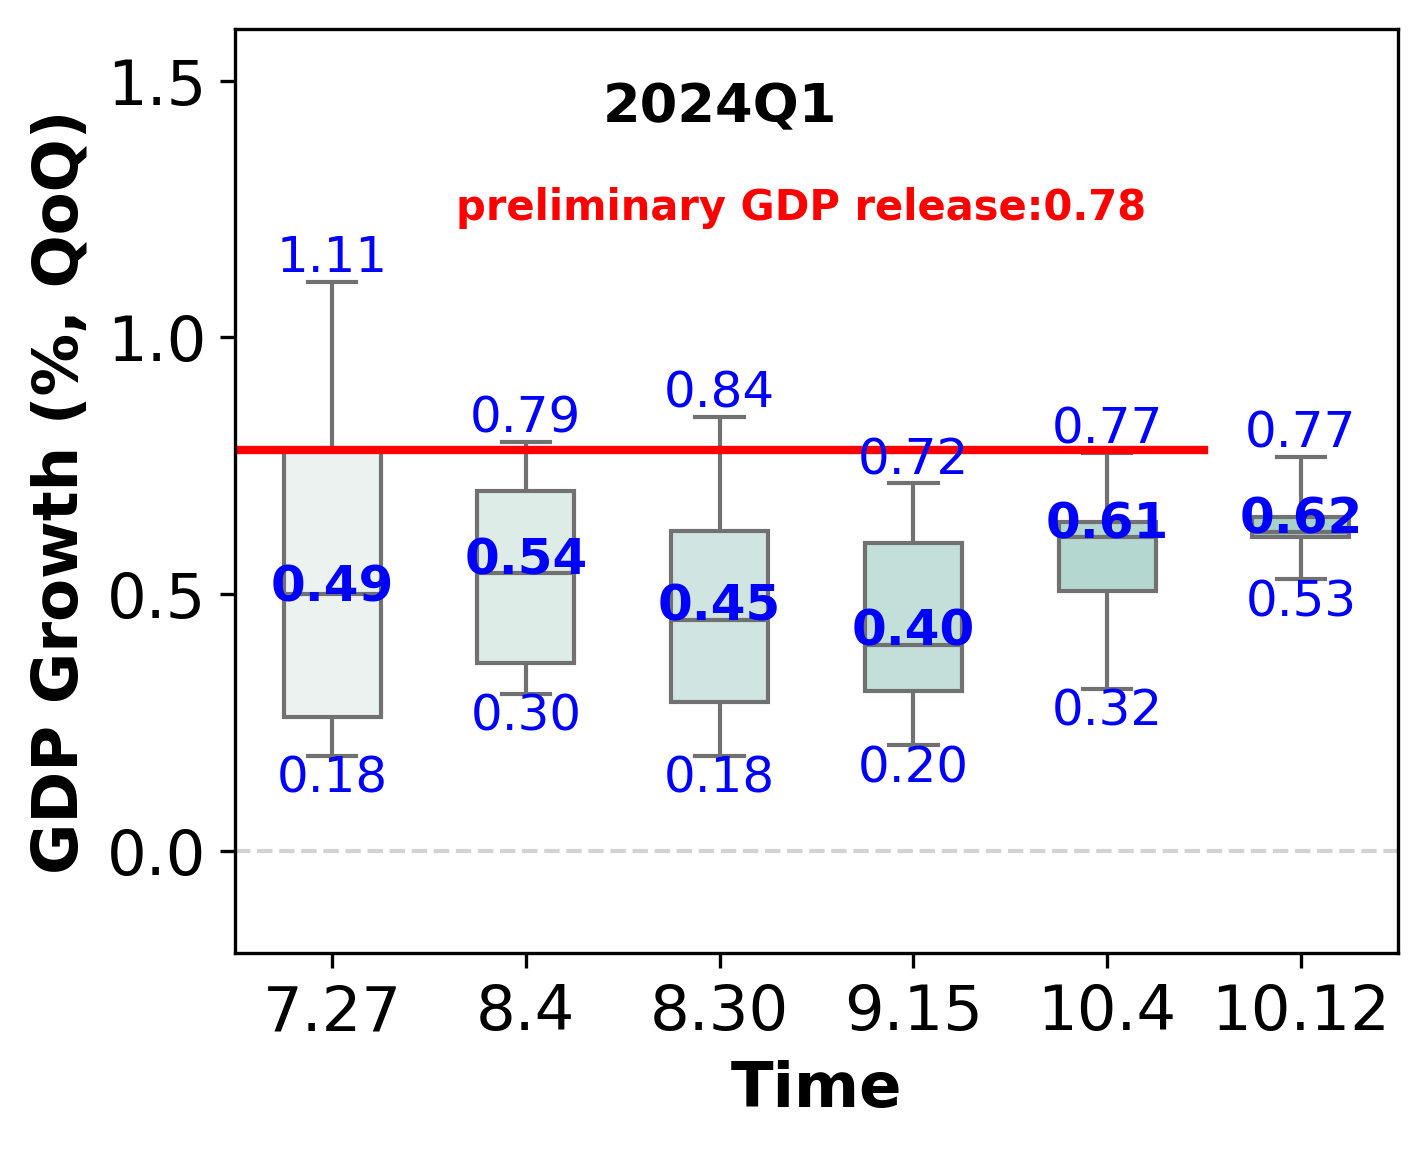

In [226]:
# sns.color_palette()
# sns.set_palette('hls',1)
# sns.reset_orig()
# sns.color_palette(palette=None)
# sns.set(color_codes=True)

fs = 12

plt.rc('font', size=15) 
fig, ax = plt.subplots(figsize=(5,4), dpi=300)
box_plot = sns.boxplot(
    x = [x[1] for x in bp.stack().index],
    y = bp.stack().loc[[x for x in bp.stack().index]],
    ax = ax,
    whis=(0, 100),
    width=0.5, palette=sns.color_palette("light:#5A9",n_colors=12), saturation=1,  linewidth=1)


plt.ylabel('GDP Growth (%, QoQ)', weight='bold')
plt.xlabel('Time', weight='bold')


medians = np.array(mean_list)
for xtick in box_plot.get_xticks():
    t=plt.text(xtick, medians[xtick], "{:.2f}".format(medians[xtick]),
            horizontalalignment='center',size=fs,color='blue', weight='semibold')
#     t.set_bbox(dict(facecolor='w', alpha=0.5, edgecolor='None'))

medians = np.array(min_list)
for xtick in box_plot.get_xticks():
    plt.text(xtick, medians[xtick]-0.07, "{:.2f}".format(medians[xtick]),
            horizontalalignment='center',size=fs,color='blue')#,weight='semibold')
    
medians = np.array(max_list)
for xtick in box_plot.get_xticks():
    plt.text(xtick, medians[xtick]+0.02, "{:.2f}".format(medians[xtick]),
            horizontalalignment='center',size=fs,color='blue')#,weight='semibold')    
    
# adj_hgt = -0.05
# plt.text(-0.4, +0.03+adj_hgt, '- 95% 분위값',
#             horizontalalignment='left',size=fs-2,color='blue')#,weight='semibold')  
# plt.text(1.0, 0.03+adj_hgt, '- 전망치',
#             horizontalalignment='left',size=fs-2,color='blue',weight='semibold')    
# plt.text(+2, 0.03+adj_hgt, '- 5% 분위값',
#             horizontalalignment='left',size=fs-2,color='blue')#,weight='semibold')  


plt.text(2, 1.45, '2024Q1',
            horizontalalignment='center',verticalalignment='center',size=fs+1,color='k',weight='semibold')  

# plt.text(14, 1.45, '2분기',
#             horizontalalignment='center',verticalalignment='center',size=fs+1,color='k',weight='semibold') 
# plt.text(26, 1.35, '22024\n1분기',
#             horizontalalignment='center',verticalalignment='center',size=fs+1,color='k',weight='semibold') 
# plt.text(35, 1.35, '2분기',
#             horizontalalignment='center',verticalalignment='center',size=fs+1,color='k',weight='semibold') 

plt.axhline(y=0,ls='--',lw=1, color='lightgray')


# plt.axvline(x=11.5,ls='--',lw=1, color='black')
# plt.axvline(x=20.5,ls='--',lw=1, color='black')
# plt.axvline(x=32.5,ls='--',lw=1, color='black')

pre_end=0.5
plt.plot([-0.5,4.5],[0.78,0.78],lw=2,color='red')
plt.text(4.2, 1.23, 'preliminary GDP release:0.78',
            horizontalalignment='right',size=10,color='red',weight='semibold')  


# plt.plot([-0.5,4.5],[0.4,0.4],lw=2,color='purple')
# plt.text(4.2, 0.33, 'Official Outlook:0.4',
#             horizontalalignment='right',size=10,color='purple',weight='semibold')  

# plt.plot([7.5,11.5],[0.5,0.5],lw=2,color='purple')
# plt.text(9.5, 0.43, '(4월 점검:0.5)',
#             horizontalalignment='center',size=10,color='purple',weight='semibold')  

# pre_end=0.5
# plt.plot([7.5,20.5],[0.625,0.625],lw=2,color='red')
# plt.text(19.5, 0.53, '(잠정:0.625)',
#             horizontalalignment='center',size=10,color='red',weight='semibold')  

# box_plot = sns.boxplot(
#     x = [x[1] for x in bp1.stack().index],
#     y = bp1.stack().loc[[x for x in bp1.stack().index]],
#     ax = ax,
#     width=0.5, palette=sns.color_palette("Reds"), saturation=1,  linewidth=1)

# x1 = 3.6; x2 = 4.4
# y1 = 0.37; y2 = 1.09
# plt.plot([x1,x2],[y1,y1],lw=2,color='red')
# plt.plot([x1,x1],[y2,y1],lw=2,color='red')
# plt.plot([x2,x2],[y1,y2],lw=2,color='red')
# plt.plot([x2,x1],[y2,y2],lw=2,color='red')

# x1 = 6.6; x2 = 7.4
# y1 = 0.23; y2 = 1.15
# plt.plot([x1,x2],[y1,y1],lw=2,color='red')
# plt.plot([x1,x1],[y2,y1],lw=2,color='red')
# plt.plot([x2,x2],[y1,y2],lw=2,color='red')
# plt.plot([x2,x1],[y2,y2],lw=2,color='red')

plt.xlim((-0.5,5.5))
plt.ylim((-0.2,1.6))


# plt.savefig('./fig/now_ts_t_{}_longterm_.png'.format(TODAY), bbox_inches='tight', dpi=300)

## By Models

In [224]:
models = pd.DataFrame({'3.15 (1/4)':SAM['3.15 (1/4)']},index=BM['3.15 (1/4)'])

In [ ]:
models

,3.15 (1/4)
BEM1,0.59
BEM2,0.56
BEM3,0.57
DFM,0.67
LBVAR,NaN
TFM,0.98
T-M,0.56
VAR,0.49
LQR,0.62
ARIMA,0.82


In [ ]:
# models.index = ['BEM1','BEM2','BEM3','DFM','LBVAR','TFM','T-M','VAR','LQR','ARIMA','SVR-KNN','RF-DVS','S-XGB']

In [ ]:
mtypes = {'core':['ARIMA','LQR','VAR','BEM1','BEM2','BEM3'],
          'big':['LBVAR','DFM','TFM','T-M'],
          'ml':['SVR-KNN','RF-DVS','S-XGB','CRNN']}

In [ ]:
models = models.loc[mtypes['core']+mtypes['big']+mtypes['ml'][:-1]]

In [ ]:
from itertools import cycle, islice

In [ ]:
temp = [{models.index[i]:models.iloc[i,0]} for i in range(len(models))]
temp = pd.DataFrame(temp)

In [ ]:
temp.index = temp.columns

In [ ]:
# my_colors = list(islice(cycle(['b', 'r', 'g', 'y', 'k']), None, len(models)))
# my_colors = ['g', 'b']*5 # <-- this concatenates the list to itself 5 times.
# my_colors = [(0.5,0.4,0.5), (0.75, 0.75, 0.25)]*5 # <-- make two custom RGBs and repeat/alternate them over all the bar elements.
# my_colors = [(x/10.0, x/20.0, 0.75) for x in range(len(models))] # <-- Quick gradient example along the Red/Green dimensions.

In [ ]:
temp = temp.drop(['LBVAR'],axis=0).drop(['LBVAR'],axis=1)
# temp = temp.drop(['LQR'],axis=0).drop(['LQR'],axis=1)

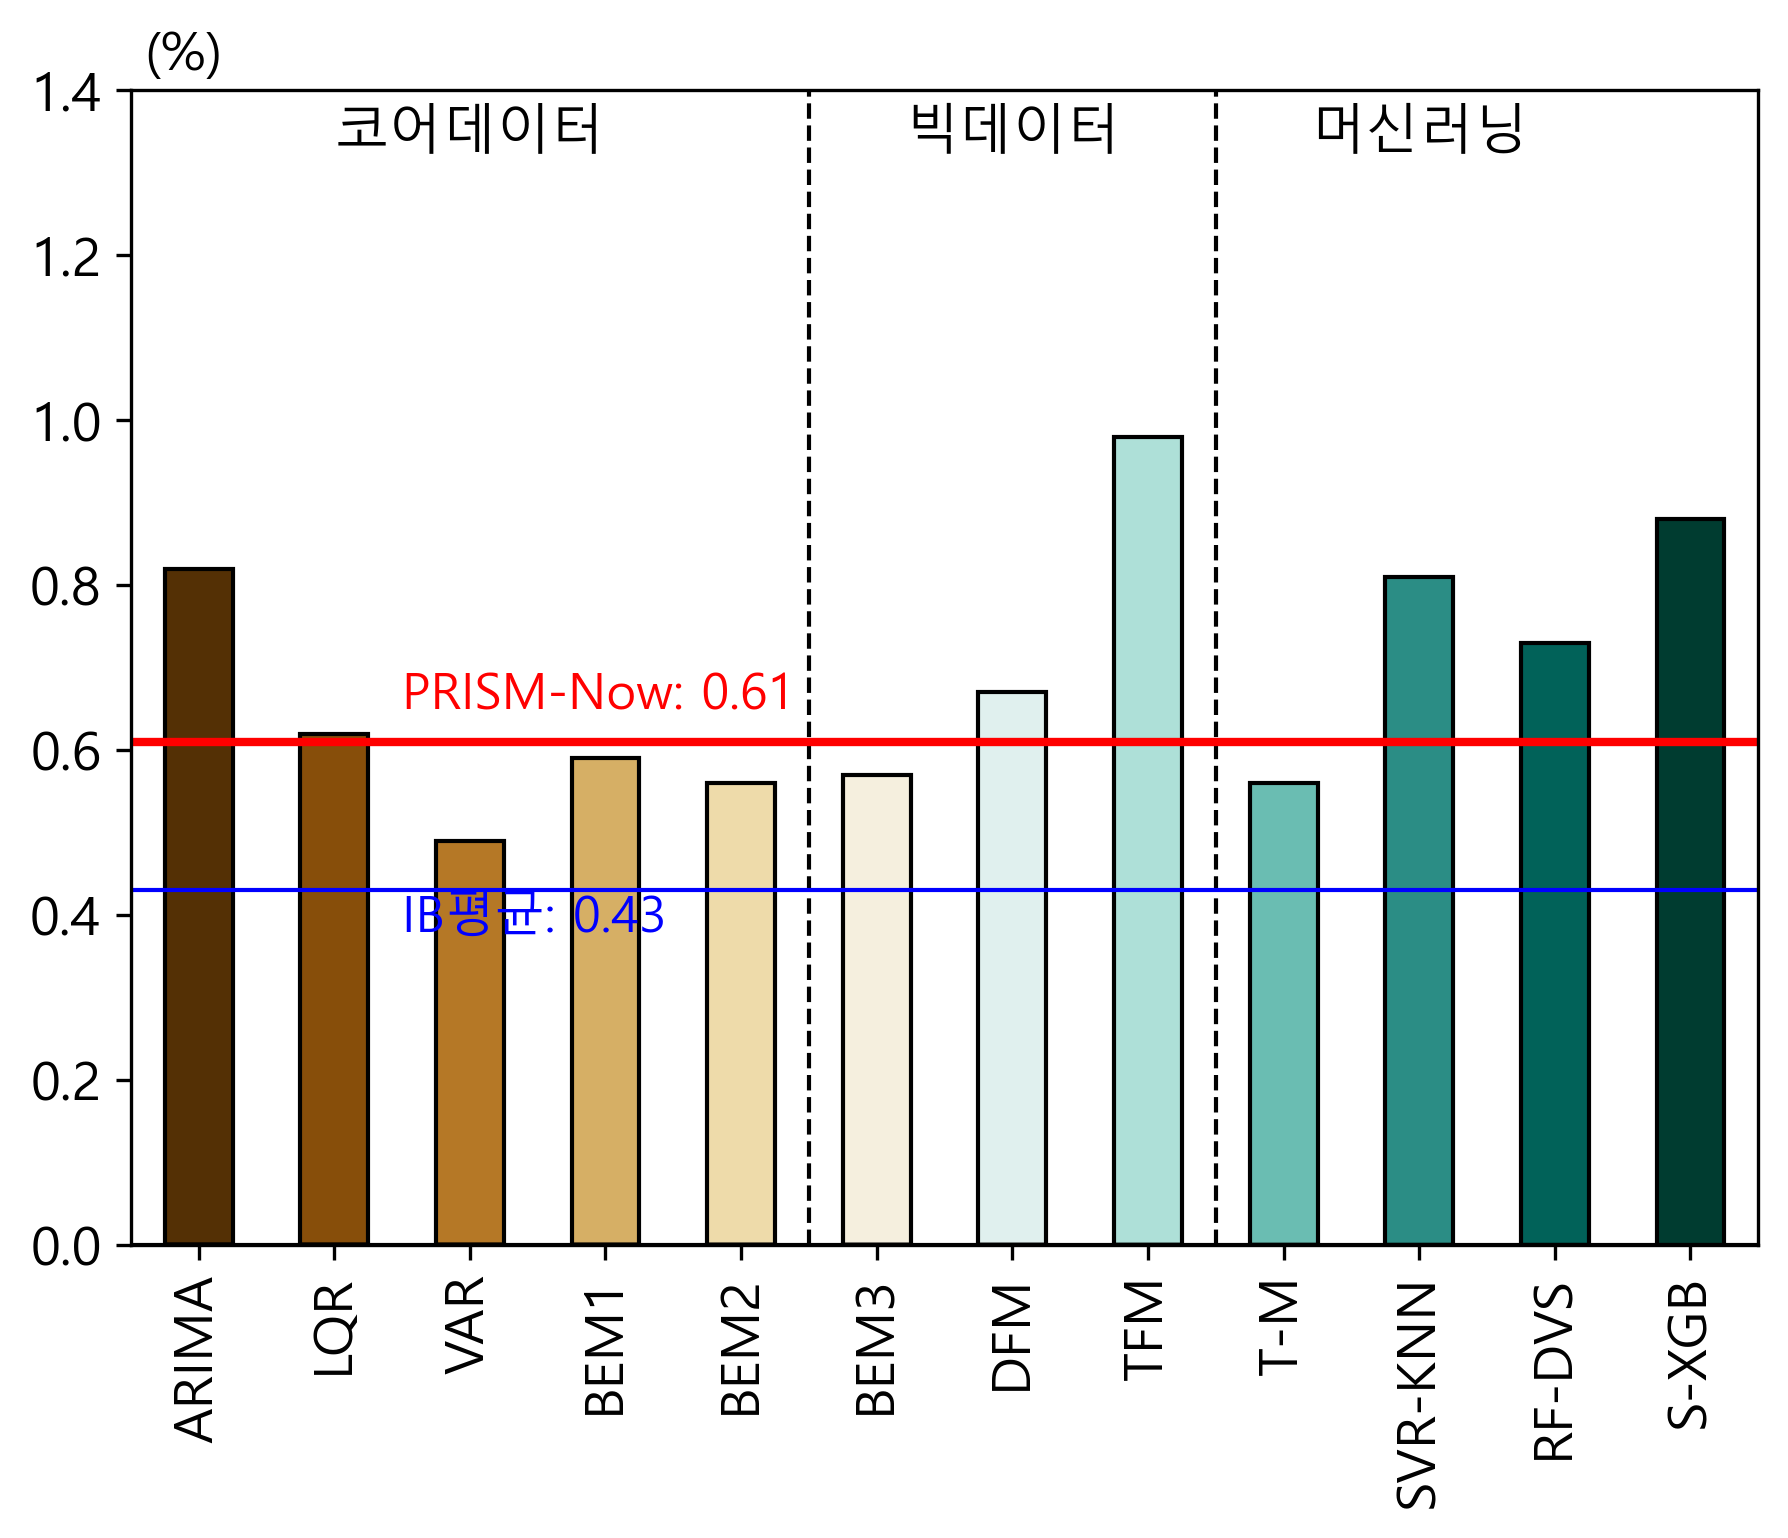

In [ ]:
plt.rc('font', size=13)        # 기본 폰트 크기
# plt.rc('axes', labelsize=20)   # x,y축 label 폰트 크기
# plt.rc('xtick', labelsize=50)  # x축 눈금 폰트 크기 
# plt.rc('ytick', labelsize=20)  # y축 눈금 폰트 크기
# plt.rc('legend', fontsize=20)  # 범례 폰트 크기
# plt.rc('figure', titlesize=50) # figure title 폰트 크기

# plt.figure(figsize=(7,5), dpi=300)
fig, ax = plt.subplots(figsize=(7,5), dpi=300)

temp.plot(kind='bar', stacked=True, colormap='BrBG', ax=ax, legend=False, edgecolor = 'k') #, color=my_colors)
plt.axvline(x=4.5,ls='--',lw=1, color='black')
plt.axvline(x=7.5,ls='--',lw=1, color='black')

yh=1.4
plt.ylim((-0.,yh))
plt.text(-0.4,yh+.025,'(%)')

plt.text(2.,yh-.07,'코어데이터',horizontalalignment='center')
plt.text(6.,  yh-.07,'빅데이터',horizontalalignment='center')
plt.text(9. ,yh-.07,'머신러닝',horizontalalignment='center')


plt.axhline(y=0.61,ls='-',lw=2, color='red')
plt.text(1.5, 0.65, 'PRISM-Now: 0.61',
            horizontalalignment='left',size=12,color='red')#,weight='semibold') 

plt.axhline(y=0.43,ls='-',lw=1, color='blue')
plt.text(1.5, 0.38, 'IB평균: 0.43',
            horizontalalignment='left',size=12,color='blue')#,weight='semibold') 

plt.axhline(y=0,ls='-',lw=1, color='black')

plt.savefig('./fig/now_models_{}_present.png'.format(TODAY), bbox_inches='tight', dpi=300)

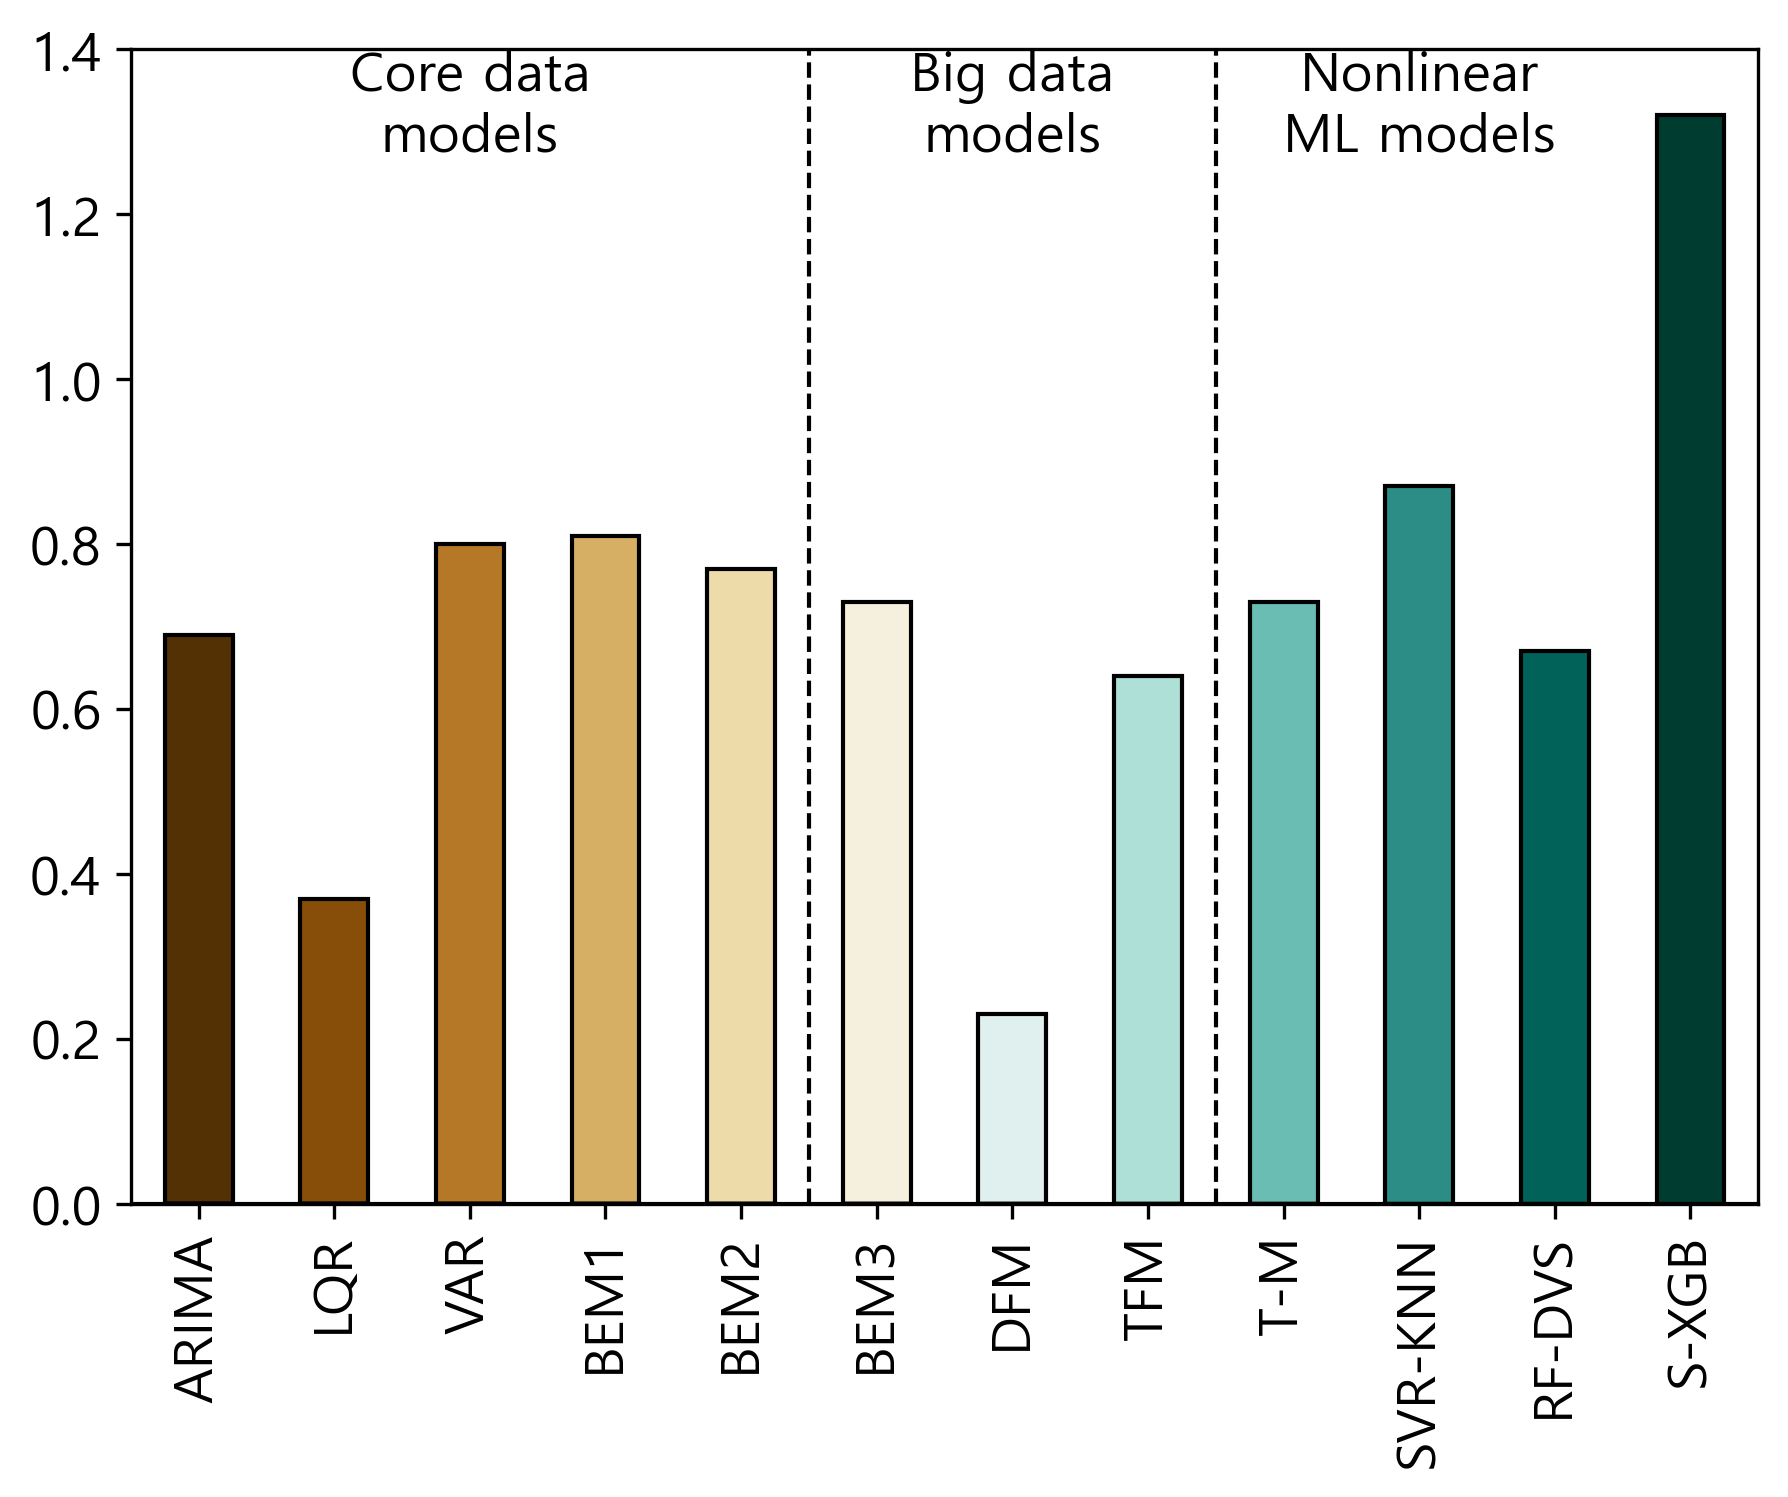

In [ ]:
plt.rc('font', size=13)        # 기본 폰트 크기
# plt.rc('axes', labelsize=20)   # x,y축 label 폰트 크기
# plt.rc('xtick', labelsize=50)  # x축 눈금 폰트 크기 
# plt.rc('ytick', labelsize=20)  # y축 눈금 폰트 크기
# plt.rc('legend', fontsize=20)  # 범례 폰트 크기
# plt.rc('figure', titlesize=50) # figure title 폰트 크기

# plt.figure(figsize=(7,5), dpi=300)
fig, ax = plt.subplots(figsize=(7,5), dpi=300)

temp.plot(kind='bar', stacked=True, colormap='BrBG', ax=ax, legend=False, edgecolor = 'k') #, color=my_colors)
plt.axvline(x=4.5,ls='--',lw=1, color='black')
plt.axvline(x=7.5,ls='--',lw=1, color='black')

yh=1.4
plt.ylim((-0.,yh))
# plt.text(-0.4,yh+.025,'(%)')

plt.text(2,yh-.07,'Core data\nmodels',horizontalalignment='center', verticalalignment='center')
plt.text(6.,  yh-.07,'Big data\nmodels',horizontalalignment='center', verticalalignment='center')
plt.text(9. ,yh-.07,'Nonlinear\nML models',horizontalalignment='center', verticalalignment='center')


# plt.axhline(y=0.61,ls='-',lw=2, color='red')
# plt.text(1.5, 0.65, 'PRISM-Now: 0.61',
#             horizontalalignment='left',size=12,color='red')#,weight='semibold') 

# plt.axhline(y=0.42,ls='-',lw=1, color='blue')
# plt.text(1.5, 0.38, 'IB평균: 0.42',
#             horizontalalignment='left',size=12,color='blue')#,weight='semibold') 

plt.axhline(y=0,ls='-',lw=1, color='black')

plt.savefig('./fig/paper_now_models_{}.png'.format(TODAY), bbox_inches='tight', dpi=300)

## Fan Chart

In [ ]:
os.getcwd()

'E:\\8.work\\9.BOK\\ensemble'

In [ ]:
all_dat = pd.read_csv('../nowcast/res/all_dat_H{}.csv'.format(TODAY), index_col=0)

In [ ]:
n_list = range(1,100)

In [ ]:
QXD = pd.DataFrame([[np.percentile(pd.DataFrame(XXR[i]).dropna(),p) for p in n_list] for i in XXR.keys()])
QXD.columns = ['p'+str(p) for p in n_list]
QXD.index = XXR.keys()

In [ ]:
# QXD = pd.DataFrame(columns=['p'+str(i) for i in n_list]) #copy.deepcopy(QXR)#

# for t in tqdm(XXR.keys()):
#     for i in range(len(n_list)):
#         mu_0 = MXR.loc[t,'mean']
#         sigma_0 = MXR.loc[t,'std']   
#         nu_0 = params_hat.loc[t,'nu']
#         tau_0 = params_hat.loc[t,'tau']
        
    
#         sstq_ = SST(mu_0, sigma_0, nu_0, tau_0)
#         QXD.loc[t,'p'+str(n_list[i])] = sstq_.q(n_list[i]/100)
        
# QXD = QXD.astype('float64')

In [ ]:
DAT = QXD

col_num = int((len(n_list)-1)/2)
col = list(sns.color_palette("Blues", n_colors=col_num+10).as_hex()) 
col_ = col[-col_num:]+[col[i] for i in range(len(col)-1,-1+len(col)-col_num,-1)]

p_list = ['p'+str(n) for n in n_list]

In [ ]:
len(p_list), len(n_list), len(col), len(col_)

(99, 99, 59, 98)

In [ ]:
GDP_qxd = DAT.loc[['7.27 (3/4)','7.27 (4/4)']]

In [ ]:
# GDP_qxd

In [ ]:
GDP = all_dat['GDP(SA)'].dropna()

In [ ]:
GDP.index = pd.PeriodIndex([str(x)[:4]+'-'+str(x)[-2:] for x in GDP.index], freq='Q')

In [ ]:
GDP_now = qval_.loc[['7.27 (3/4)','7.27 (4/4)'],'yhat']

In [ ]:
GDP_now.index = [str(x) for x in pd.PeriodIndex(['2023-09','2023-12'], freq='Q')]
GDP_qxd.index = [str(x) for x in pd.PeriodIndex(['2023-09','2023-12'], freq='Q')]

In [ ]:
GDP_now = pd.concat([GDP[-1:],GDP_now])

In [ ]:
GDP_qxd.loc['2023Q2'] = GDP[-1]

In [ ]:
GDP_qxd = GDP_qxd.loc[['2023Q2','2023Q3','2023Q4'],:]

In [ ]:
GDP_qxd

,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,p12,p13,p14,p15,p16,p17,p18,p19,p20,p21,p22,p23,p24,p25,p26,p27,p28,p29,p30,p31,p32,p33,p34,p35,p36,p37,p38,p39,p40,p41,p42,p43,p44,p45,p46,p47,p48,p49,p50,p51,p52,p53,p54,p55,p56,p57,p58,p59,p60,p61,p62,p63,p64,p65,p66,p67,p68,p69,p70,p71,p72,p73,p74,p75,p76,p77,p78,p79,p80,p81,p82,p83,p84,p85,p86,p87,p88,p89,p90,p91,p92,p93,p94,p95,p96,p97,p98,p99
2023Q2,0.6000,0.6000,0.6000,0.6000,0.600,0.6000,0.6000,0.6000,0.6000,0.600,0.6000,0.6000,0.6000,0.6000,0.600,0.6000,0.6000,0.6000,0.6000,0.600,0.6000,0.6000,0.6000,0.6000,0.6000,0.6000,0.6000,0.6000,0.6000,0.600,0.6000,0.6000,0.6000,0.6000,0.600,0.6000,0.6000,0.6000,0.6000,0.600,0.6000,0.6000,0.6000,0.6000,0.6000,0.6000,0.6000,0.6000,0.6000,0.600,0.6000,0.6000,0.6000,0.6000,0.600,0.6000,0.6000,0.6000,0.6000,0.600,0.6000,0.6000,0.6000,0.6000,0.6000,0.6000,0.6000,0.6000,0.6000,0.600,0.6000,0.6000,0.6000,0.6000,0.6000,0.6000,0.6000,0.6000,0.6000,0.600,0.6000,0.6000,0.6000,0.6000,0.6000,0.6000,0.6000,0.6000,0.6000,0.600,0.6000,0.6000,0.6000,0.6000,0.6000,0.6000,0.6000,0.6000,0.6000
2023Q3,0.1154,0.1308,0.1462,0.1616,0.177,0.1924,0.2078,0.2232,0.2386,0.242,0.2442,0.2464,0.2486,0.2508,0.253,0.2552,0.2574,0.2596,0.2600,0.260,0.2600,0.2600,0.2600,0.2600,0.2600,0.2600,0.2600,0.2744,0.2942,0.314,0.3338,0.3536,0.3734,0.3932,0.413,0.4328,0.4407,0.4418,0.4429,0.444,0.4451,0.4462,0.4473,0.4484,0.4495,0.4530,0.4585,0.4640,0.4695,0.475,0.4805,0.4860,0.4915,0.4970,0.508,0.5256,0.5432,0.5608,0.5784,0.596,0.6136,0.6312,0.6488,0.6636,0.6735,0.6834,0.6933,0.7032,0.7131,0.723,0.7329,0.7428,0.7509,0.7542,0.7575,0.7608,0.7641,0.7674,0.7707,0.774,0.7773,0.7806,0.7839,0.7872,0.7905,0.7938,0.7971,0.8004,0.8037,0.807,0.8121,0.8352,0.8583,0.8814,0.9045,0.9276,0.9507,0.9738,0.9969
2023Q4,0.2666,0.2732,0.2798,0.2864,0.293,0.2996,0.3062,0.3128,0.3194,0.324,0.3284,0.3328,0.3372,0.3416,0.346,0.3504,0.3548,0.3592,0.3681,0.378,0.3879,0.3978,0.4077,0.4176,0.4275,0.4374,0.4473,0.4532,0.4576,0.462,0.4664,0.4708,0.4752,0.4796,0.484,0.4884,0.5026,0.5224,0.5422,0.562,0.5818,0.6016,0.6214,0.6412,0.6610,0.6736,0.6802,0.6868,0.6934,0.700,0.7066,0.7132,0.7198,0.7264,0.730,0.7300,0.7300,0.7300,0.7300,0.730,0.7300,0.7300,0.7300,0.7340,0.7450,0.7560,0.7670,0.7780,0.7890,0.800,0.8110,0.8220,0.8303,0.8314,0.8325,0.8336,0.8347,0.8358,0.8369,0.838,0.8391,0.8420,0.8530,0.8640,0.8750,0.8860,0.8970,0.9080,0.9190,0.930,0.9418,0.9616,0.9814,1.0012,1.0210,1.0408,1.0606,1.0804,1.1002


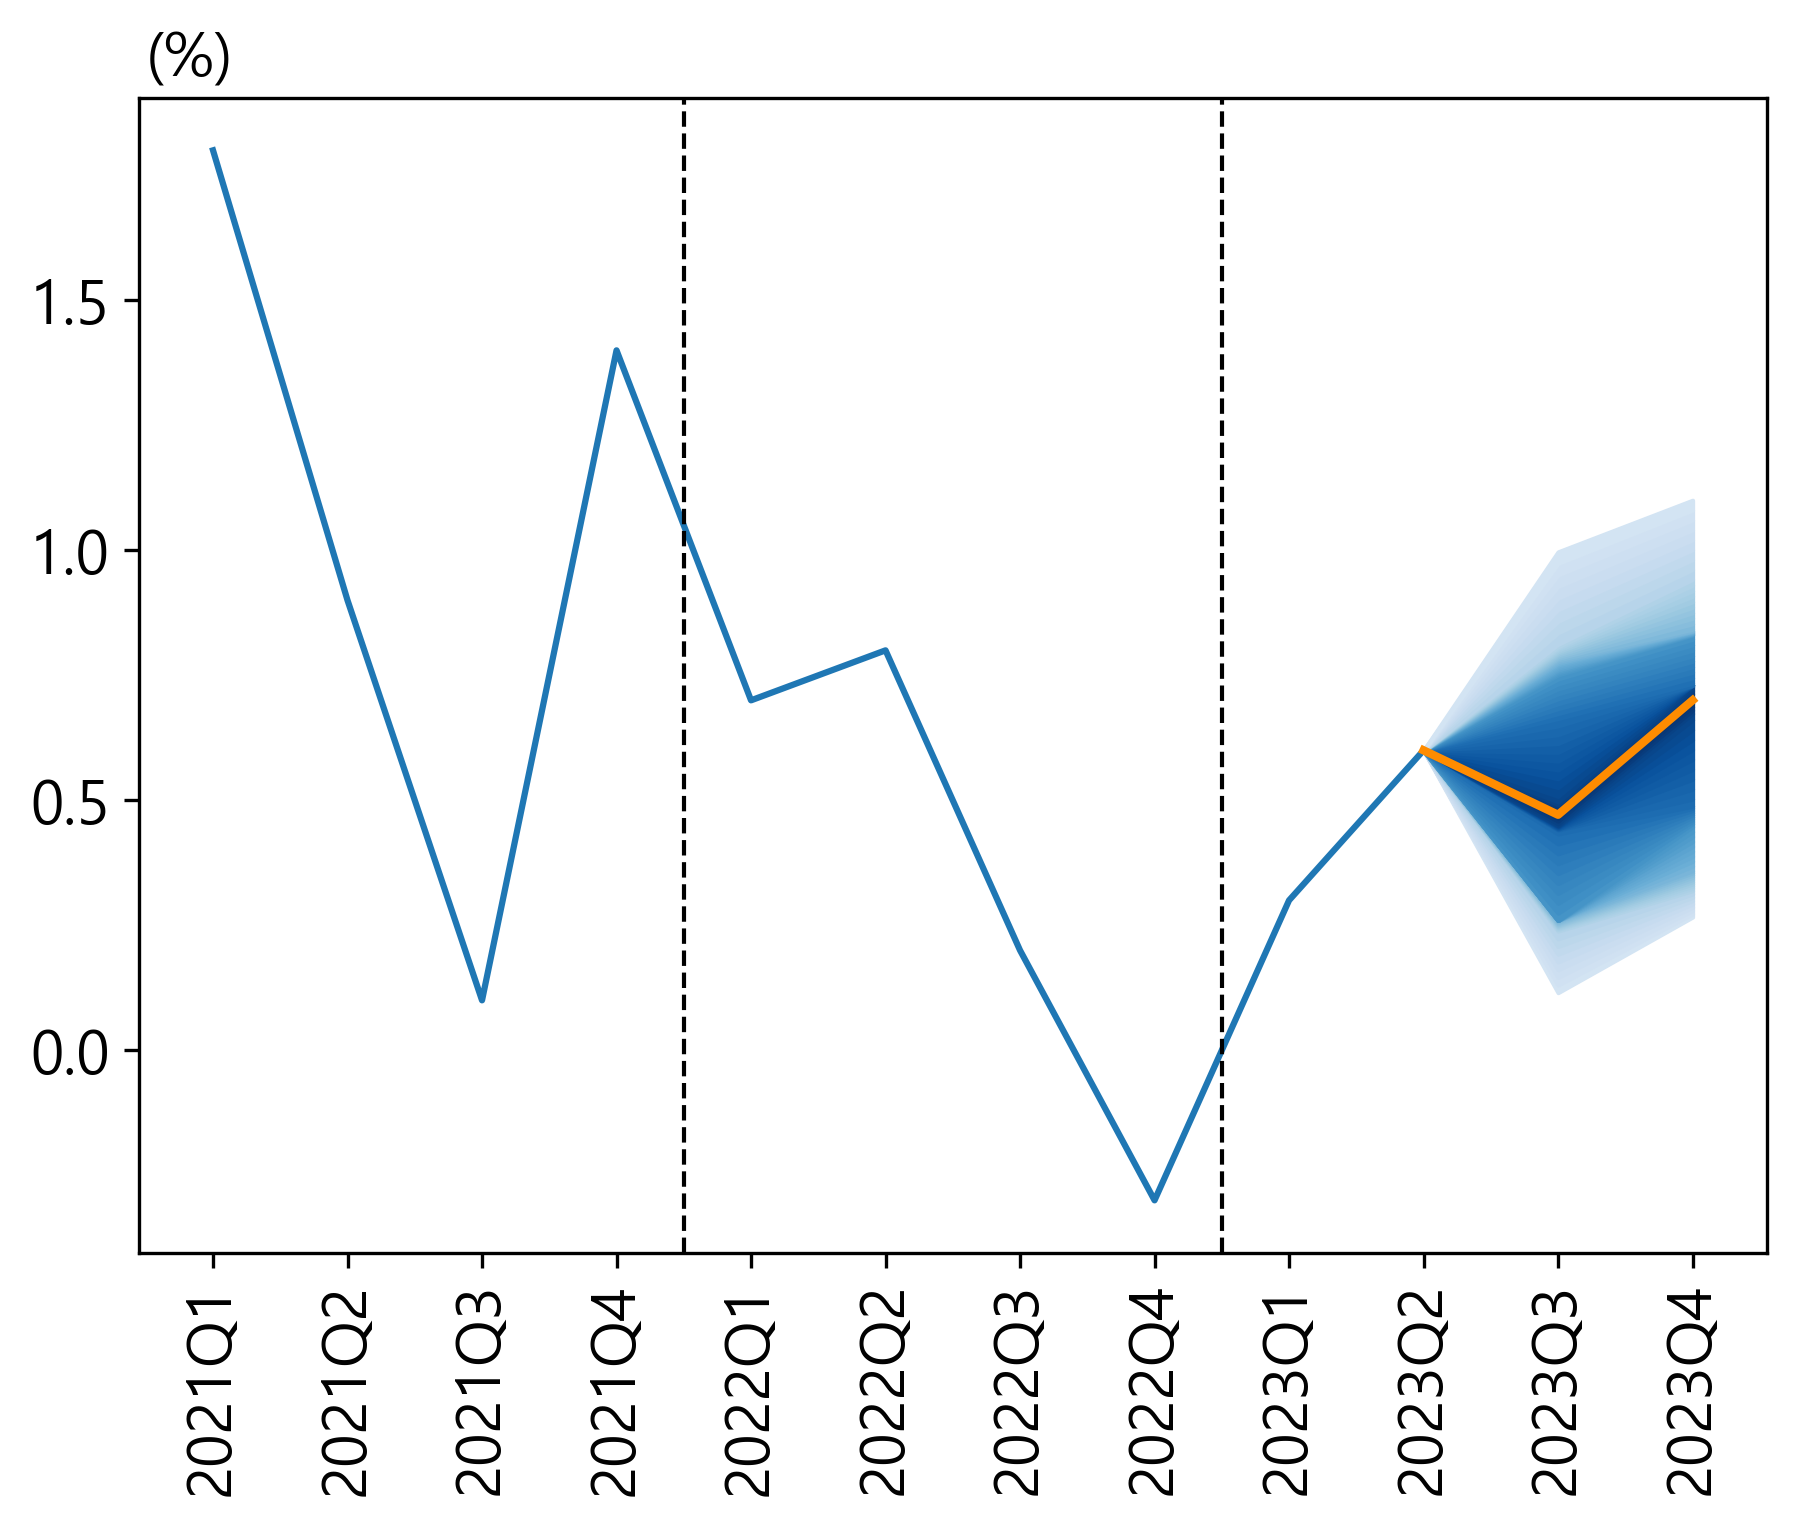

In [ ]:
fig, ax = plt.subplots(figsize=(7,5), dpi=300)

fs=14.5
plt.xticks(rotation=90, fontsize=fs)
plt.yticks(fontsize=fs)
plt.text(-0.5,1.95,'(%)',fontsize=fs)

S = '2021Q1'
T = '2023Q2'
plt.plot([str(x) for x in GDP[S:T].index],GDP[S:T])
plt.plot([str(x) for x in GDP_now.index],GDP_now, color='darkorange',lw=2)

plt.axvline(x=3.5,ls='--',lw=1, color='black')
plt.axvline(x=7.5,ls='--',lw=1, color='black')

for i in range(len(p_list)-1):
    plt.fill_between(GDP_qxd.index, GDP_qxd[p_list[i]], GDP_qxd[p_list[i+1]], color=col_[i], alpha=1)
    
plt.savefig('./fig/fanchart_{}.png'.format(TODAY), bbox_inches='tight', dpi=300)    